[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ksachdeva/rethinking-tensorflow-probability/blob/master/notebooks/11_god_spiked_the_integers.ipynb)

# Chapter 11 - God Spiked the Integers

## Imports and utility functions


In [1]:
# Install packages that are not installed in colab
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    %tensorflow_version 2.X
    
    !pip install watermark
    !pip install arviz

In [2]:
%load_ext watermark

In [3]:
from functools import partial

# Core
import numpy as np
import arviz as az
import pandas as pd
import xarray as xr
import tensorflow as tf
import tensorflow_probability as tfp
import scipy.stats as stats

# visualization 
import matplotlib.pyplot as plt

# aliases
tfd = tfp.distributions
tfb = tfp.bijectors
Root = tfd.JointDistributionCoroutine.Root

In [4]:
%watermark -p numpy,tensorflow,tensorflow_probability,arviz,scipy,pandas

numpy 1.18.1
tensorflow 2.1.0
tensorflow_probability 0.9.0
arviz 0.6.1
scipy 1.4.1
pandas 1.0.1


In [5]:
# config of various plotting libraries
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

In [6]:
assert tf.__version__ >= '2.1.0', "Tensorflow version should be at minimum 2.1.0"
assert tfp.__version__ >= '0.9.0', "TFP version should be at minimum 0.9.0"

### Tensorflow MCMC sampling helpers

In [7]:
# not working (compiling) my models whether I am 
# running on gpu or not !
# USE_XLA = tf.test.gpu_device_name() == '/device:GPU:0'

# Forcing it to false for now
USE_XLA = False

In [8]:
NUMBER_OF_CHAINS  = 2
NUMBER_OF_BURNIN  = 500
NUMBER_OF_SAMPLES = 500
NUMBER_OF_LEAPFROG_STEPS = 4

def _trace_to_arviz(trace=None,
                   sample_stats=None,
                   observed_data=None,
                   prior_predictive=None,
                   posterior_predictive=None,
                   inplace=True):

    if trace is not None and isinstance(trace, dict):
        trace = {k: np.swapaxes(v.numpy(), 1, 0)
                 for k, v in trace.items()}
    if sample_stats is not None and isinstance(sample_stats, dict):
        sample_stats = {k: v.numpy().T for k, v in sample_stats.items()}
    if prior_predictive is not None and isinstance(prior_predictive, dict):
        prior_predictive = {k: v[np.newaxis]
                            for k, v in prior_predictive.items()}
    if posterior_predictive is not None and isinstance(posterior_predictive, dict):
        if isinstance(trace, az.InferenceData) and inplace == True:
            return trace + az.from_dict(posterior_predictive=posterior_predictive)
        else:
            trace = None

    return az.from_dict(
        posterior=trace,
        sample_stats=sample_stats,
        prior_predictive=prior_predictive,
        posterior_predictive=posterior_predictive,
        observed_data=observed_data,
    )

@tf.function(autograph=False, experimental_compile=USE_XLA)
def run_chain(init_state,
              bijectors, 
              step_size, 
              target_log_prob_fn, 
              num_leapfrog_steps=NUMBER_OF_LEAPFROG_STEPS,
              num_samples=NUMBER_OF_SAMPLES,
              burnin=NUMBER_OF_BURNIN,
              ):    

    def _trace_fn_transitioned(_, pkr):
        return (
            pkr.inner_results.inner_results.log_accept_ratio
        )

    hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
                    target_log_prob_fn,
                    num_leapfrog_steps=num_leapfrog_steps,
                    step_size=step_size)         

    inner_kernel = tfp.mcmc.TransformedTransitionKernel(
        inner_kernel=hmc_kernel,
        bijector=bijectors)       

    kernel = tfp.mcmc.SimpleStepSizeAdaptation(
        inner_kernel=inner_kernel,
        target_accept_prob=.8,
        num_adaptation_steps=int(0.8*burnin),
        log_accept_prob_getter_fn=lambda pkr: pkr.inner_results.log_accept_ratio
    )    

    results, sampler_stat = tfp.mcmc.sample_chain(
        num_results=num_samples,
        num_burnin_steps=burnin,
        current_state=init_state,
        kernel=kernel,
        trace_fn=_trace_fn_transitioned)

    return results, sampler_stat

def sample_posterior(jdc, 
                      observed_data, 
                      params, 
                      num_chains=NUMBER_OF_CHAINS,
                      init_state=None, 
                      bijectors=None,                              
                      num_samples=NUMBER_OF_SAMPLES, 
                      burnin=NUMBER_OF_BURNIN):       
    
    if init_state is None:
        init_state = list(jdc.sample(NUMBER_OF_CHAINS)[:-1])
        
    if bijectors is None:
        bijectors = [tfb.Identity() for i in init_state]


    target_log_prob_fn = lambda *x: jdc.log_prob(x + observed_data)    
    step_size = 0.1
    results, sample_stats = run_chain(init_state,
                                  bijectors,
                                  step_size=step_size,
                                  target_log_prob_fn=target_log_prob_fn,                                      
                                  num_samples=num_samples, 
                                  burnin=burnin)

    stat_names = ['mean_tree_accept']
    sampler_stats = dict(zip(stat_names, [sample_stats]))    
    posterior = dict(zip(params, results))
    return _trace_to_arviz(trace=posterior, sample_stats=sampler_stats)

### Dataset URLS

In [9]:
# You could change base url to local dir or a remoate raw github content
_BASE_URL = "https://raw.githubusercontent.com/ksachdeva/rethinking-tensorflow-probability/master/data"

CHIMPANZEES_DATASET_PATH = f"{_BASE_URL}/chimpanzees.csv"
UCBADMIT_DATASET_PATH = f"{_BASE_URL}/UCBadmit.csv"
KLINE_DATASET_PATH = f"{_BASE_URL}/Kline.csv"

## Code 11.1

Authors start the chapter by highlighting one key difference between **Generalized Linear Models** and **Gaussian Linear Models**. He says, that unlike Gaussian Linear Models where we had some interpretation of parameters, in the case of **GLM** it is the combination of parameters that matter.

Most common & **useful** GLM models are about **counts** but they are also difficult to model. What is the reason for that ?

He says - "When we *wish* to predict the outcome in the form of counts, the scale of parameters is **never the same** as the scale of outcome. This is another way of saying that it is the combination of parameters that help in prediction and hence some where we lose human intution that could have connected the parmaeters with the outcome.


**Binomial Regression** -: model the outcome (count) when both of the categories are known.

**Poisson Regression** -: model the outcome (count) when the maximum count is unknown.



In [10]:
d = pd.read_csv(CHIMPANZEES_DATASET_PATH, sep=";")

## Code 11.2


We aim to build index variables instead of using dummy variables. Below is a quick way to do it. Treatment here is about the 4 possible situations.

1. prosoc_left= 0 and condition= 0: Two food items on right and no partner. 
2. prosoc_left= 1 and condition= 0: Two food items on left and no partner.
3. prosoc_left= 0 and condition= 1: Two food items on right and partner present.
4. prosoc_left= 1 and condition= 1: Two food items on left and partner present.

In [11]:
# In the book there is an additional 1 in the code snippet.
# That is because of R as in R index does not starts with 0

d["treatment"] = d.prosoc_left + 2 * d.condition

## Code 11.3

In [12]:
d.reset_index().groupby(
    ["condition", "prosoc_left", "treatment"]).count()["index"]

condition  prosoc_left  treatment
0          0            0            126
           1            1            126
1          0            2            126
           1            3            126
Name: index, dtype: int64

In [13]:
d.describe()

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left,treatment
count,504.000000,252.00000,504.000000,504.000000,504.000000,504.000000,504.00000,504.000000,504.000000
mean,4.000000,5.00000,0.500000,3.500000,36.500000,0.500000,0.56746,0.579365,1.500000
std,2.001987,2.00398,0.500497,1.709522,20.803253,0.500497,0.49592,0.494151,1.119145
min,1.000000,2.00000,0.000000,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000
25%,2.000000,3.00000,0.000000,2.000000,18.750000,0.000000,0.00000,0.000000,0.750000
50%,4.000000,5.00000,0.500000,3.500000,36.500000,0.500000,1.00000,1.000000,1.500000
75%,6.000000,7.00000,1.000000,5.000000,54.250000,1.000000,1.00000,1.000000,2.250000
max,7.000000,8.00000,1.000000,6.000000,72.000000,1.000000,1.00000,1.000000,3.000000


## Code 11.4

In [14]:
def model_11_1(alpha_scale):
    def _generator():
      alpha = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=alpha_scale), sample_shape=1))
      logit = alpha
      pulled_left = yield tfd.Independent(tfd.Binomial(total_count=1., logits=logit), reinterpreted_batch_ndims=1)

    return tfd.JointDistributionCoroutine(_generator, validate_args=True)    
    
jdc_11_1 = model_11_1(alpha_scale=10.)

## Code 11.5

In [15]:
prior = jdc_11_1.sample(1000)

## Code 11.6

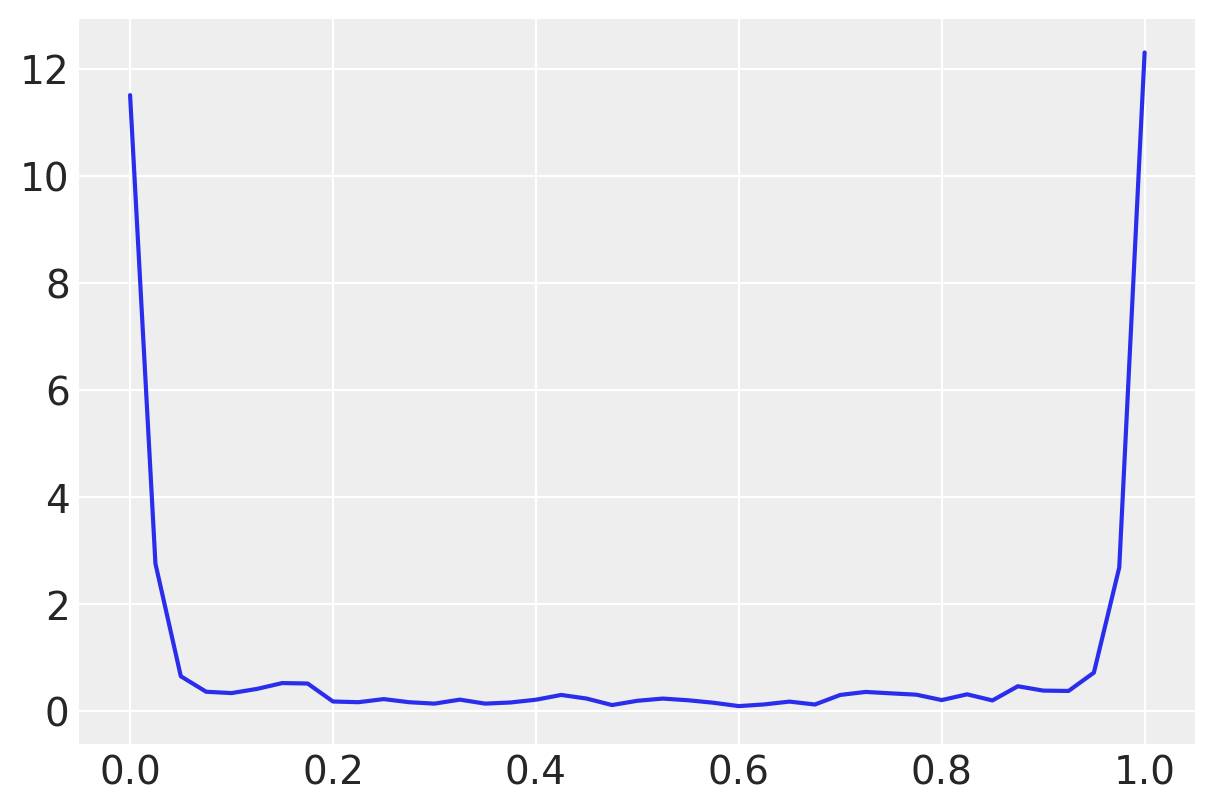

In [16]:
p = tf.math.sigmoid(prior[0])
az.plot_kde(p, bw=0.3);

Most of the probability mass in the above plot is piled up near zero or one. A flat prior in the logit space is not a flat prior in the outcome probability space.

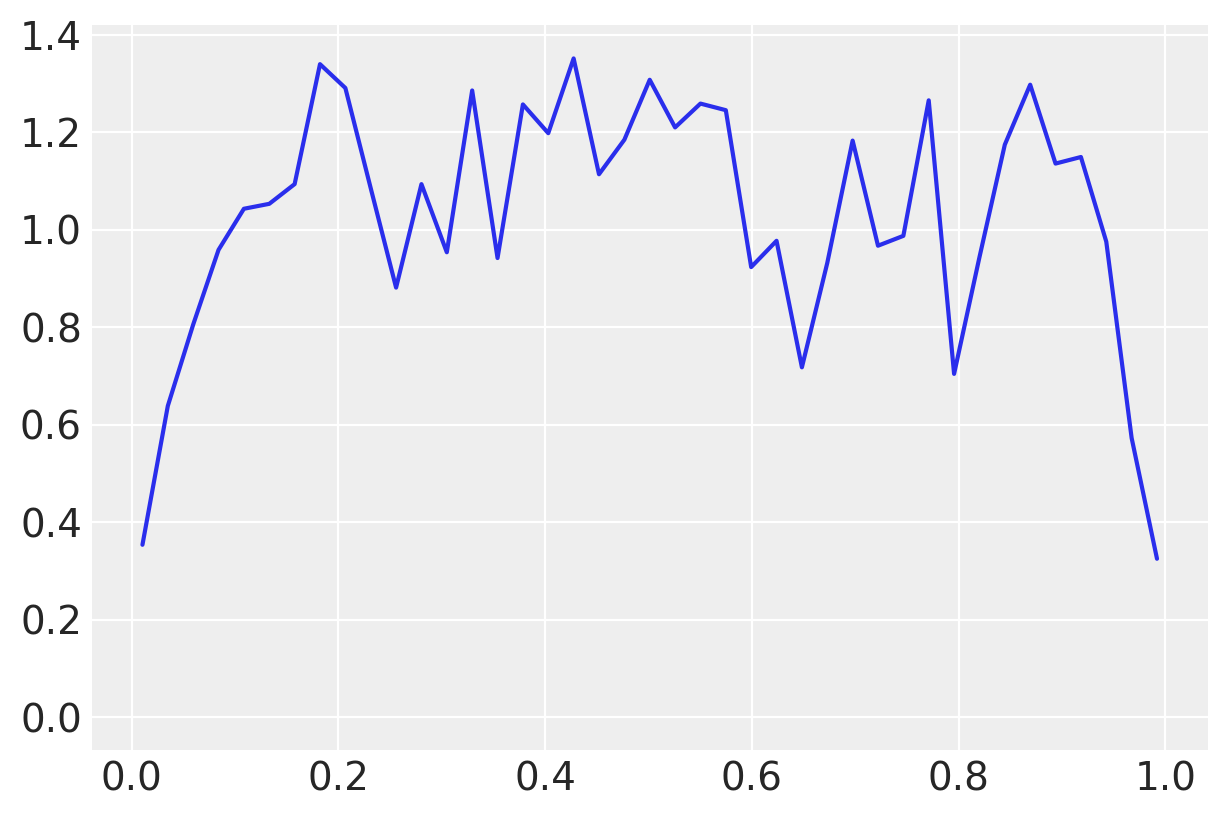

In [17]:
jdc_11_1b = model_11_1(alpha_scale=1.5)
prior_with_1_5 = jdc_11_1b.sample(1000)

p = tf.math.sigmoid(prior_with_1_5[0])

az.plot_kde(p, bw=0.3);

A more concentrated Normal(0,1.5) prior produces something more reasonable

## Code 11.7 (Very slow prior sampling with TFP - File issue)

In [18]:
def model_11_2(treatments):
    def _generator():
      alpha = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1.5), sample_shape=1))
      beta_treatment = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=10.0), sample_shape=4))
    
      logit = alpha + tf.squeeze(tf.gather(beta_treatment, treatments, axis=-1))
        
      pulled_left = yield tfd.Independent(
          tfd.Binomial(total_count=1., logits=logit), reinterpreted_batch_ndims=1)

    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_11_2 = model_11_2(tf.cast(d.treatment.values, dtype=tf.int32))

In [19]:
# Sampling is quite slow, not sure why ? ... at this point there
# is no MCMC etc involved so not sure why it is the case
prior_a, prior_b, _ = jdc_11_2.sample(1000)

In [20]:
prior_a = prior_a.numpy()
prior_b = prior_b.numpy()

In [21]:
prior_a.shape, prior_b.shape

((1000, 1), (1000, 4))

In [22]:
def compute_p_for_given_treatment(t):
    p = prior_a[:,0] + prior_b[:,t]
    return tf.math.sigmoid(p)

p = np.array(list(map(compute_p_for_given_treatment, np.arange(4)))).T

p.shape

(1000, 4)

## Code 11.8 

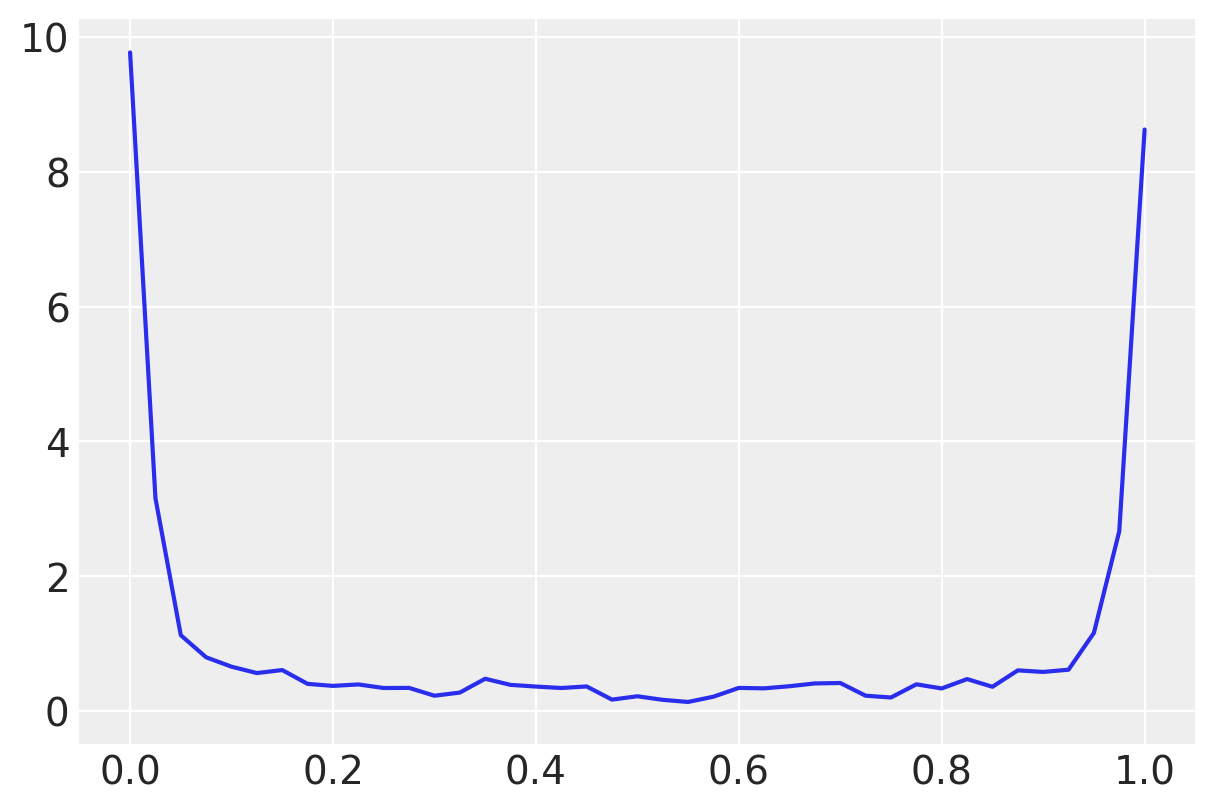

In [23]:
az.plot_kde(np.abs(p[:, 0] - p[:, 1]), bw=0.3);

## Code 11.9 (Very slow prior sampling with TFP - File issue)

Sample model as 11_2 but with a different scale for beta_treatment

In [24]:
def model_11_3(treatments):
    def _generator():
      alpha = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1.5), sample_shape=1))
      beta_treatment = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.5), sample_shape=4))
    
      logit = alpha + tf.squeeze(tf.gather(beta_treatment, treatments, axis=-1))
        
      pulled_left = yield tfd.Independent(
          tfd.Binomial(total_count=1., logits=logit), reinterpreted_batch_ndims=1)

    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_11_3 = model_11_3(tf.cast(d.treatment.values, dtype=tf.int32))

# Sampling is quite slow, not sure why ? ... at this point there
# is no MCMC etc involved so not sure why it is the case
prior_a, prior_b, _ = jdc_11_3.sample(1000)

prior_a = prior_a.numpy()
prior_b = prior_b.numpy()


p = np.array(list(map(compute_p_for_given_treatment, np.arange(4)))).T

np.mean(np.abs(p[:, 0] - p[:, 1]))

0.09807605

## Code 11.10

In [25]:
# prior trimmed data list
dat_list = {"pulled_left": d.pulled_left.values,
            "actor": d.actor.values - 1,
            "treatment": d.treatment.values}

## Code 11.11

In [26]:
def model_11_4(actors, treatments):
    def _generator():
      alpha = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1.5), sample_shape=7))
      beta_treatment = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.5), sample_shape=4))
        
      term1 = tf.gather(alpha, actors, axis=-1)
      term2 = tf.gather(beta_treatment, treatments, axis=-1)
    
      logit = term1 + term2
        
      pulled_left = yield tfd.Independent(
          tfd.Binomial(total_count=1., logits=logit), reinterpreted_batch_ndims=1)

    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_11_4 = model_11_4(
    tf.cast(dat_list["actor"], dtype=tf.int32),
    tf.cast(dat_list["treatment"], dtype=tf.int32))


jdc_11_4.sample()

(<tf.Tensor: shape=(7,), dtype=float32, numpy=
 array([ 1.0298193 , -1.0534368 , -0.71444297,  1.0288594 ,  3.4192257 ,
        -0.26172343,  0.85806906], dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([ 0.00565516, -0.09283759,  1.2950946 ,  0.54995054], dtype=float32)>,
 <tf.Tensor: shape=(504,), dtype=float32, numpy=
 array([0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0.,
        1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0.,
        0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0.,
        0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1.,
        1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 

In [27]:
init_state = [
    tf.zeros([NUMBER_OF_CHAINS, 7]),
    tf.zeros([NUMBER_OF_CHAINS, 4])
]

bijectors = [
    tfb.Identity(),
    tfb.Identity()
]

observed_data = (tf.cast(dat_list["pulled_left"], dtype=tf.float32), )

trace_11_4 = sample_posterior(
    jdc_11_4, 
    observed_data=observed_data, 
    init_state=init_state,
    bijectors=bijectors,
    params=["alpha", "beta_treatment"])


az.summary(trace_11_4)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha[0],-0.420,0.343,-1.081,0.142,0.018,0.013,360.0,330.0,362.0,367.0,1.02
alpha[1],3.884,0.763,2.547,5.277,0.051,0.037,224.0,217.0,231.0,236.0,1.01
alpha[2],-0.739,0.343,-1.298,-0.127,0.018,0.013,351.0,351.0,347.0,431.0,1.00
alpha[3],-0.735,0.334,-1.362,-0.109,0.017,0.012,400.0,400.0,401.0,490.0,1.00
alpha[4],-0.451,0.325,-1.112,0.108,0.017,0.013,370.0,333.0,374.0,263.0,1.01
alpha[5],0.495,0.353,-0.233,1.051,0.019,0.014,342.0,342.0,340.0,310.0,1.01
alpha[6],1.956,0.433,1.272,2.868,0.022,0.016,373.0,373.0,382.0,222.0,1.03
beta_treatment[0],-0.031,0.288,-0.546,0.500,0.021,0.015,196.0,196.0,194.0,290.0,1.00
beta_treatment[1],0.480,0.295,-0.041,1.021,0.019,0.014,238.0,238.0,241.0,334.0,1.01
beta_treatment[2],-0.382,0.297,-0.972,0.132,0.018,0.014,259.0,242.0,257.0,289.0,1.01


Clearly interpretation of all these varying parameters is difficult now. The alphas above represent intercepts unique to each chimpanzee. Each of these expresses the tendency of each individual to pull the left lever. 

## Code 11.12

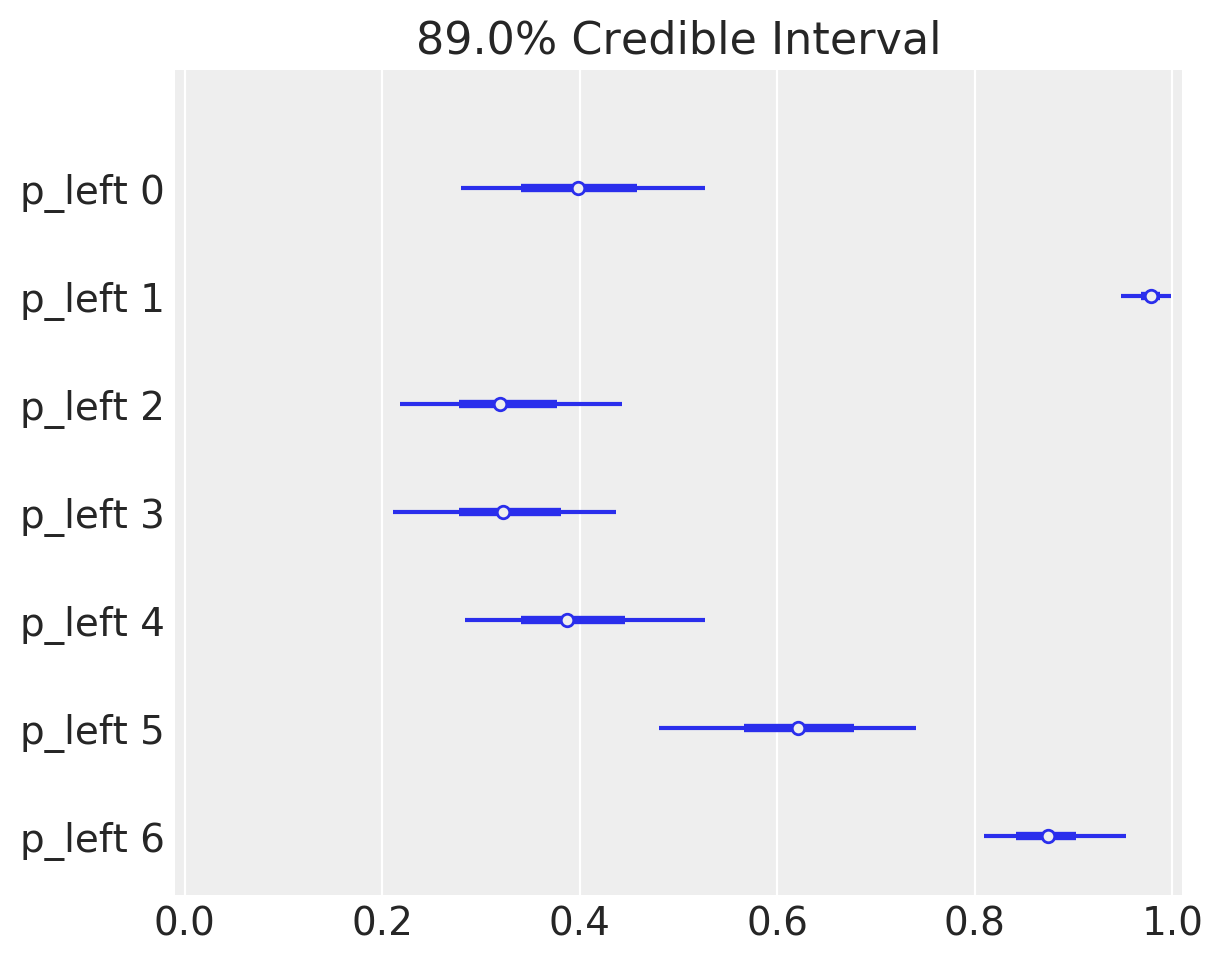

In [28]:
post = trace_11_4.posterior
p_left = tf.math.sigmoid(post["alpha"].values)
az.plot_forest({"p_left": p_left}, combined=True, credible_interval=0.89)
plt.gca().set(xlim=(-0.01, 1.01));

What above plot shows is that 0,2,3,4 show preference for right lever.
Two chimps (1 & 6) show strong preference for left lever and it is also reflected in the data

## Code 11.13

Here we are now considering treatment effects and hoping that they are estimated more precisely

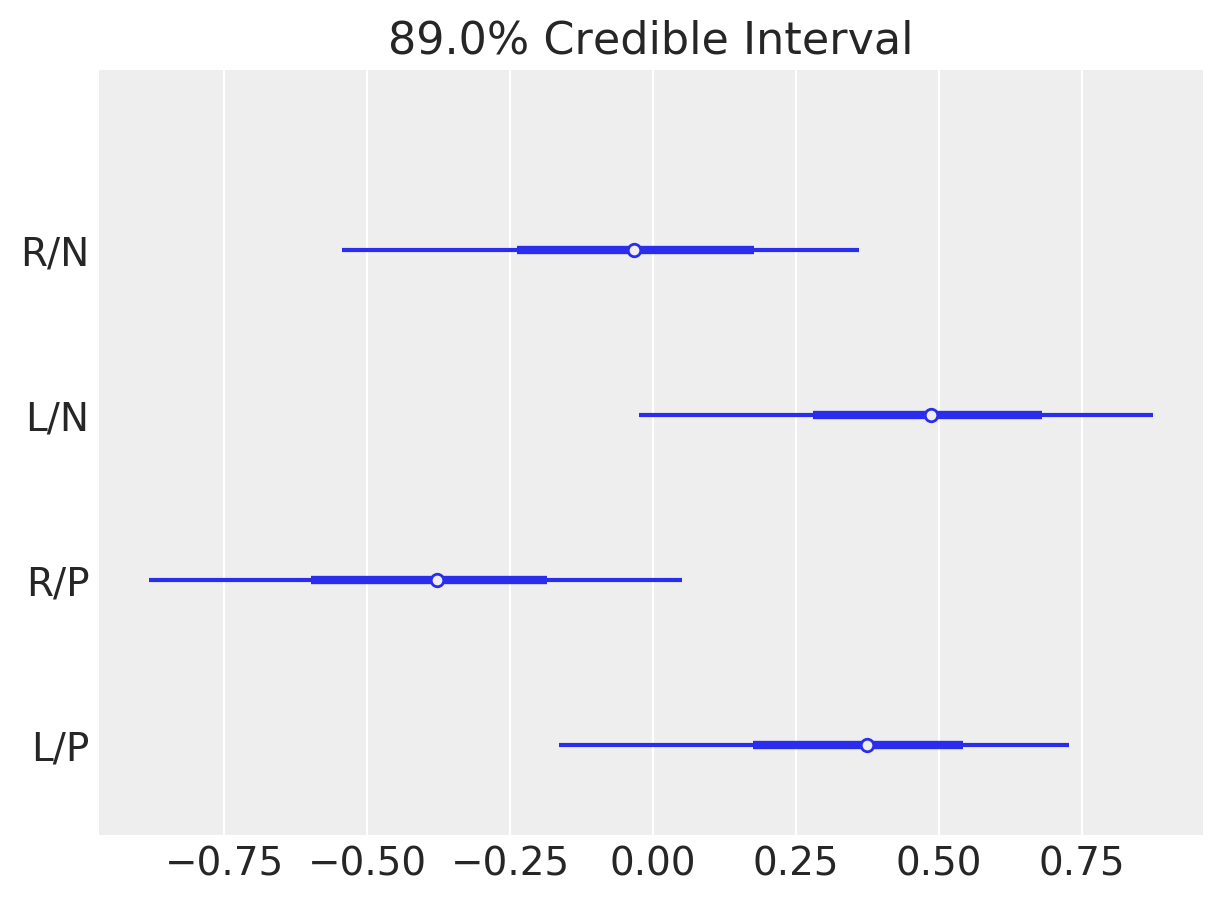

In [29]:
labs = ["R/N", "L/N", "R/P", "L/P"]
az.plot_forest(trace_11_4, combined=True,
               var_names="beta_treatment", credible_interval=0.89)
plt.gca().set_yticklabels(labs[::-1]);

* L/N => prosocial on left / no partner
* R/P => proscoial on right / partner

What we are looking for is evidence that the chimpanzees choose the prosocial option more when a partner is present. This implies comparing the first row with the third row and the second row with the fourth row

## Code 11.14

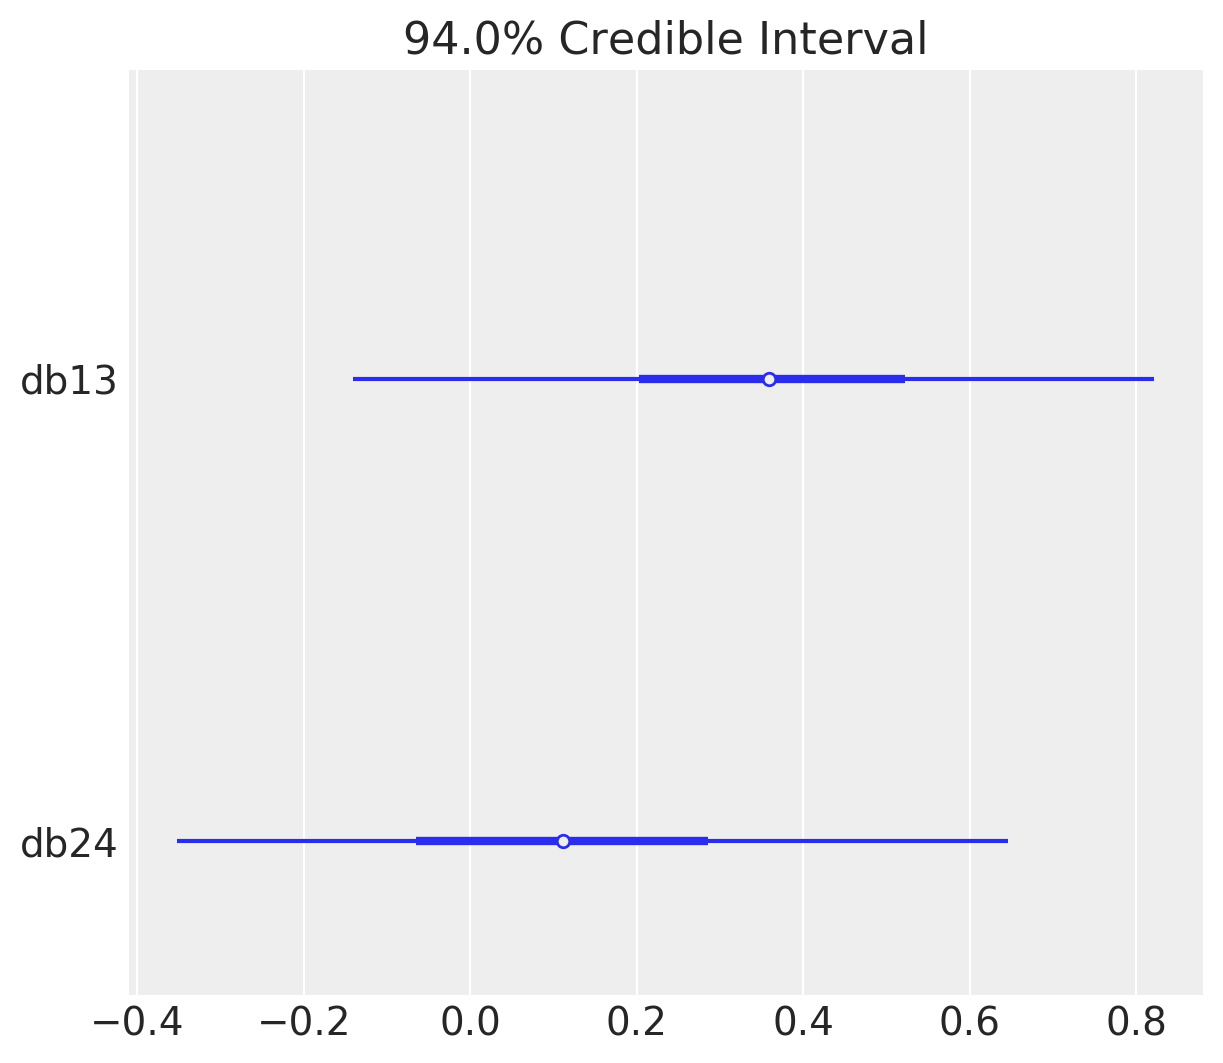

In [30]:
diffs = {"db13": post["beta_treatment"][..., 0] - post["beta_treatment"][..., 2],
         "db24": post["beta_treatment"][..., 1] - post["beta_treatment"][..., 3]}
az.plot_forest(diffs, combined=True);

db13 is the difference between no-partner/partner treatments when the prosocial option was on the right.

There is a weak evidence that individual pulled left more when the partner was absent

## Code 11.15

Compute proportion in each combination of actor & treatment

In [31]:
pl = d.groupby(["actor", "treatment"])["pulled_left"].mean().unstack()
pl.iloc[0, :]

treatment
0    0.333333
1    0.500000
2    0.277778
3    0.555556
Name: 1, dtype: float64

In [32]:
pl

treatment,0,1,2,3
actor,,,,
1,0.333333,0.500000,0.277778,0.555556
2,1.000000,1.000000,1.000000,1.000000
3,0.277778,0.611111,0.166667,0.333333
4,0.333333,0.500000,0.111111,0.444444
5,0.333333,0.555556,0.277778,0.500000
6,0.777778,0.611111,0.555556,0.611111
7,0.777778,0.833333,0.944444,1.000000


the cells contain proportions of pulls that were of the left lever

## Code 11.16

Plotting observed proportions

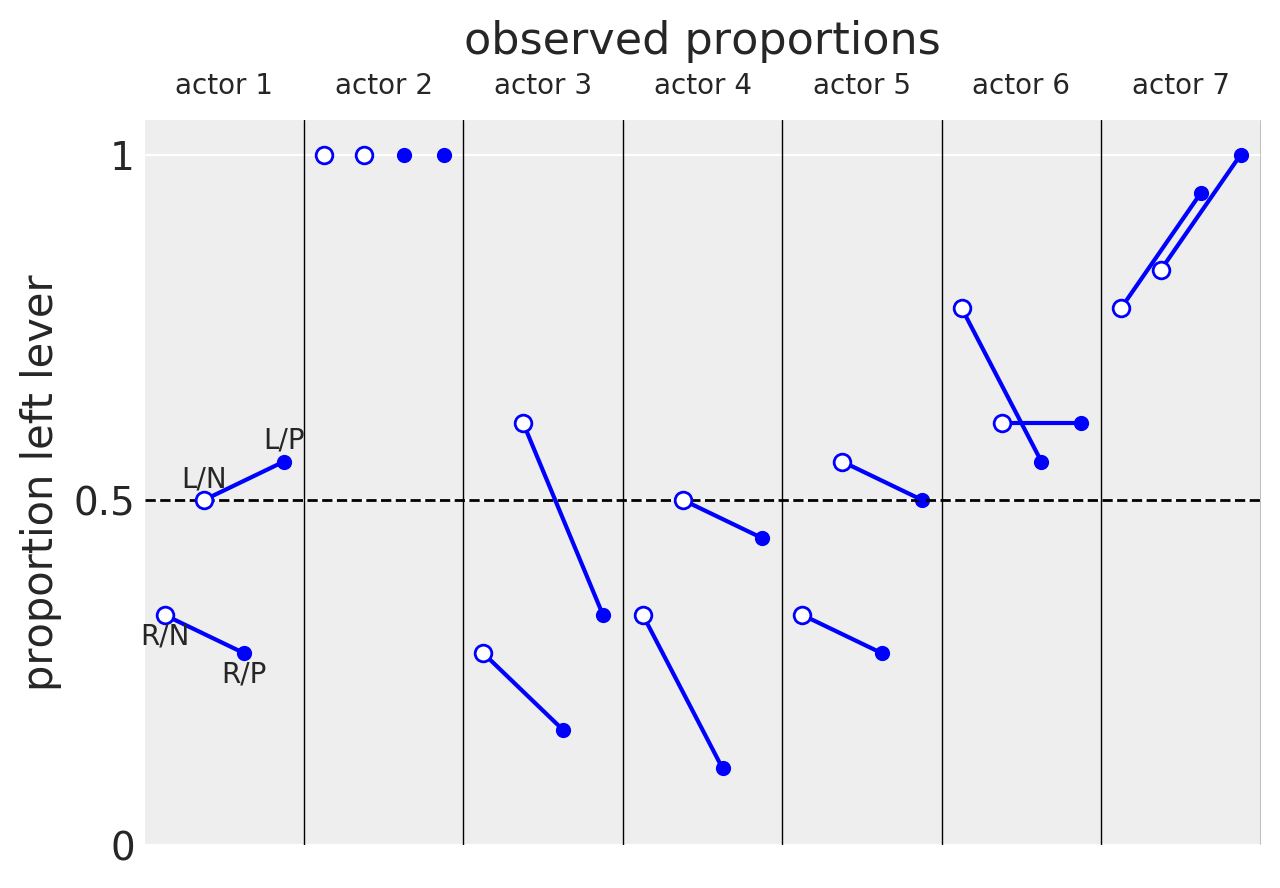

In [33]:
ax = plt.subplot(xlim=(0.5, 28.5), ylim=(0, 1.05), xlabel="",
                 ylabel="proportion left lever", xticks=[])
plt.yticks(ticks=[0, 0.5, 1], labels=[0, 0.5, 1])
ax.axhline(0.5, c="k", lw=1, ls="--")
for j in range(1, 8):
    ax.axvline((j - 1) * 4 + 4.5, c="k", lw=0.5)
for j in range(1, 8):
    ax.annotate("actor {}".format(j), ((j - 1) * 4 + 2.5, 1.1),
                ha="center", va="center", annotation_clip=False)
for j in np.delete(range(1, 8), 1):
    ax.plot((j - 1) * 4 + np.array([1, 3]), pl.loc[j, [0, 2]], "b")
    ax.plot((j - 1) * 4 + np.array([2, 4]), pl.loc[j, [1, 3]], "b")
x = np.arange(1, 29).reshape(7, 4)
ax.scatter(x[:, [0, 1]].reshape(-1), pl.values[:, [0, 1]].reshape(-1),
           edgecolor="b", facecolor="w", zorder=3)
ax.scatter(x[:, [2, 3]].reshape(-1), pl.values[:, [2, 3]].reshape(-1),
           marker=".", c="b", s=80)
yoff = 0.01
ax.annotate("R/N", (1, pl.loc[1, 0] - yoff), ha="center", va="top")
ax.annotate("L/N", (2, pl.loc[1, 1] + yoff), ha="center", va="bottom")
ax.annotate("R/P", (3, pl.loc[1, 2] - yoff), ha="center", va="top")
ax.annotate("L/P", (4, pl.loc[1, 3] + yoff), ha="center", va="bottom")
ax.set_title("observed proportions\n");

## Code 11.17

In [34]:
dat = {"actor": np.repeat(np.arange(7), 4),
       "treatment": np.tile(np.arange(4), 7)}

def compute_p_for_given_actor_treatment(params):
    a = params[0]
    t = params[1]
    p = post["alpha"].values[0][:,a] + post["beta_treatment"].values[0][:,t]
    return tf.math.sigmoid(p)

params = zip(dat["actor"], dat["treatment"])

p = np.array(list(map(compute_p_for_given_actor_treatment, params))).T

p_mu = np.mean(p, 0)
p_ci = np.percentile(p, q=(4.5, 95.5), axis=0)

## Code 11.18

In [35]:
d["side"] = d.prosoc_left  # right 0, left 1
d["cond"] = d.condition  # no partner 0, partner 1

## Code 11.19

In [36]:
dat_list2 = {"pulled_left": d.pulled_left.values,
             "actor": d.actor.values - 1,
             "side": d.side.values,
             "cond": d.cond.values}

def model_11_5(actors, sides, conds):
    def _generator():
      alpha = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1.5), sample_shape=7))
      beta_side = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.5), sample_shape=2))
      beta_cond = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.5), sample_shape=2))  
        
      term1 = tf.gather(alpha, actors, axis=-1)
      term2 = tf.gather(beta_side, sides, axis=-1)
      term3 = tf.gather(beta_cond, conds, axis=-1)  
    
      logit = term1 + term2 + term3
        
      pulled_left = yield tfd.Independent(
          tfd.Binomial(total_count=1., logits=logit), reinterpreted_batch_ndims=1)

    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_11_5 = model_11_5(
    tf.cast(dat_list2["actor"], dtype=tf.int32),
    tf.cast(dat_list2["side"], dtype=tf.int32), 
    tf.cast(dat_list2["cond"], dtype=tf.int32), 
)

jdc_11_5.sample()

(<tf.Tensor: shape=(7,), dtype=float32, numpy=
 array([ 0.9767699 ,  1.1749486 ,  1.2138085 , -0.35580763,  0.72361314,
        -0.9665023 ,  0.4772957 ], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 0.03866706, -0.09011842], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 0.29585633, -0.5992518 ], dtype=float32)>,
 <tf.Tensor: shape=(504,), dtype=float32, numpy=
 array([0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1.,
        1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1.,
        0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
        1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1.,
        1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0.,
        0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0

In [37]:
init_state = [
    tf.zeros([NUMBER_OF_CHAINS, 7]),
    tf.zeros([NUMBER_OF_CHAINS, 2]),
    tf.zeros([NUMBER_OF_CHAINS, 2])
]

bijectors = [
    tfb.Identity(),
    tfb.Identity(),
    tfb.Identity()
]

observed_data = (tf.cast(dat_list["pulled_left"], dtype=tf.float32), )

trace_11_5 = sample_posterior(
    jdc_11_5, 
    observed_data=observed_data, 
    init_state=init_state,
    bijectors=bijectors,
    params=["alpha", "beta_side", "beta_cond"])


az.summary(trace_11_5)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha[0],-0.656,0.416,-1.468,0.059,0.035,0.025,137.0,137.0,142.0,201.0,1.00
alpha[1],3.772,0.805,2.287,5.170,0.070,0.051,133.0,127.0,136.0,154.0,1.01
alpha[2],-0.959,0.433,-1.815,-0.191,0.036,0.026,145.0,145.0,149.0,158.0,1.00
alpha[3],-0.954,0.421,-1.750,-0.227,0.033,0.024,158.0,158.0,158.0,135.0,1.00
alpha[4],-0.660,0.400,-1.383,0.119,0.033,0.024,145.0,145.0,146.0,147.0,1.00
alpha[5],0.265,0.418,-0.481,1.071,0.034,0.024,150.0,150.0,155.0,206.0,1.00
alpha[6],1.747,0.469,0.706,2.466,0.036,0.026,167.0,165.0,168.0,343.0,1.01
beta_side[0],-0.201,0.305,-0.755,0.376,0.020,0.014,242.0,242.0,241.0,387.0,1.00
beta_side[1],0.477,0.308,-0.122,1.029,0.020,0.014,245.0,245.0,246.0,310.0,1.00
beta_cond[0],0.295,0.337,-0.275,0.978,0.025,0.017,186.0,186.0,186.0,383.0,1.00


## Code 11.20

We need to compute likelihoods in order to use arviz's compare method

In [38]:
def compute_and_store_log_likelihood_for_model_11_4():   

    def log_like_11_4(params):
        alpha = params[0]
        beta = params[1]                

        p = alpha[dat_list["actor"]] + beta[dat_list["treatment"]]
        
        return tfd.Binomial(total_count=1., logits=p).log_prob(dat_list["pulled_left"])

    log_likelihood_11_4 = []

    for i in range(NUMBER_OF_CHAINS):
        alpha = trace_11_4.posterior["alpha"].values[i]
        beta  = trace_11_4.posterior["beta_treatment"].values[i]
        
        params = zip(alpha, beta)
        
        log_likelihood = np.array(list(map(log_like_11_4, params)))
        log_likelihood_11_4.append(log_likelihood)

    log_likelihood_11_4 = np.array(log_likelihood_11_4)

    # we need to insert this in the sampler_stats
    sample_stats_11_4 = trace_11_4.sample_stats

    coords = [sample_stats_11_4.coords['chain'], sample_stats_11_4.coords['draw'], np.arange(504)]

    sample_stats_11_4["log_likelihood"] = xr.DataArray(
        log_likelihood_11_4, 
        coords=coords,  
        dims=['chain', 'draw', 'log_likelihood_dim_0'])
    
compute_and_store_log_likelihood_for_model_11_4()

In [39]:
def compute_and_store_log_likelihood_for_model_11_5():   

    def log_like_11_5(params):
        alpha = params[0]
        beta_side = params[1]                
        beta_cond = params[2]

        p = alpha[dat_list2["actor"]] + beta_side[dat_list2["side"]] +  beta_cond[dat_list2["cond"]]
        
        return tfd.Binomial(total_count=1., logits=p).log_prob(dat_list2["pulled_left"])

    log_likelihood_11_5 = []

    for i in range(NUMBER_OF_CHAINS):
        alpha = trace_11_5.posterior["alpha"].values[i]
        beta_side  = trace_11_5.posterior["beta_side"].values[i]
        beta_cond  = trace_11_5.posterior["beta_cond"].values[i]
        
        params = zip(alpha, beta_side, beta_cond)
        
        log_likelihood = np.array(list(map(log_like_11_5, params)))
        log_likelihood_11_5.append(log_likelihood)

    log_likelihood_11_5 = np.array(log_likelihood_11_5)

    # we need to insert this in the sampler_stats
    sample_stats_11_5 = trace_11_5.sample_stats

    coords = [sample_stats_11_5.coords['chain'], sample_stats_11_5.coords['draw'], np.arange(504)]

    sample_stats_11_5["log_likelihood"] = xr.DataArray(
        log_likelihood_11_5, 
        coords=coords,  
        dims=['chain', 'draw', 'log_likelihood_dim_0'])
    
compute_and_store_log_likelihood_for_model_11_5()

In [40]:
az.compare({"m11.5": trace_11_5, "m11.4": trace_11_4},   ic="loo")

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m11.5,0,531.202,7.98857,0,0.582293,19.3074,0,False,deviance
m11.4,1,531.941,8.27316,0.738438,0.417707,19.1005,1.27856,False,deviance


## Code 11.21

Since I am making use of xarray and above computation of likelihood has stored it as part of
sample_stats here is one way to see it

In [41]:
trace_11_4.sample_stats

<xarray.Dataset>
Dimensions:               (chain: 2, draw: 500, log_likelihood_dim_0: 504)
Coordinates:
  * chain                 (chain) int64 0 1
  * draw                  (draw) int64 0 1 2 3 4 5 6 ... 494 495 496 497 498 499
  * log_likelihood_dim_0  (log_likelihood_dim_0) int64 0 1 2 3 ... 501 502 503
Data variables:
    mean_tree_accept      (chain, draw) float32 1.4104309 ... -1.163147
    log_likelihood        (chain, draw, log_likelihood_dim_0) float32 -0.44346452 ... -0.27318645
Attributes:
    created_at:  2020-02-26T16:54:17.040459

## Code 11.22

This code cell in the book is showing how underneath Stan is computing the log likelihood and since I have been doing it anyways there is no need to fill this section.

See compute_and_store_log_likelihood_for_model_11_4 for the equivalent code 

In [42]:
# nothing to do here

## Code 11.23

In [43]:
post = trace_11_4.posterior

np.mean(np.exp(post["beta_treatment"][:,:, 3] - post["beta_treatment"][:,:, 1]))

<xarray.DataArray 'beta_treatment' ()>
array(0.921001, dtype=float32)

## Code 11.24

In [44]:
d = pd.read_csv(CHIMPANZEES_DATASET_PATH, sep=";")
d["treatment"] = d.prosoc_left + 2 * d.condition
d["side"] = d.prosoc_left  # right 0, left 1
d["cond"] = d.condition  # no partner 0, partner 1
d_aggregated = d.groupby(
    ["treatment", "actor", "side", "cond"])["pulled_left"].sum().reset_index()
d_aggregated.rename(columns={"pulled_left": "left_pulls"}, inplace=True)

d_aggregated

,treatment,actor,side,cond,left_pulls
0,0,1,0,0,6
1,0,2,0,0,18
2,0,3,0,0,5
3,0,4,0,0,6
4,0,5,0,0,6
5,0,6,0,0,14
6,0,7,0,0,14
7,1,1,1,0,9
8,1,2,1,0,18
9,1,3,1,0,11


## Code 11.25

In [45]:
dat = dict(zip(d_aggregated.columns, d_aggregated.values.T))

def model_11_6(actors, treatments):
    def _generator():
      alpha = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1.5), sample_shape=7))
      beta_treatment = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.5), sample_shape=4))
              
      term1 = tf.gather(alpha, actors, axis=-1)
      term2 = tf.gather(beta_treatment, treatments, axis=-1)
          
      logit = term1 + term2 
        
      pulled_left = yield tfd.Independent(
          tfd.Binomial(total_count=18., logits=logit), reinterpreted_batch_ndims=1)

    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_11_6 = model_11_6(
    tf.cast(dat["actor"] - 1, dtype=tf.int32),
    tf.cast(dat["treatment"], dtype=tf.int32))

jdc_11_6.sample()

(<tf.Tensor: shape=(7,), dtype=float32, numpy=
 array([ 2.1072302 , -4.271906  ,  1.6374586 , -1.5962895 ,  0.06059516,
        -0.21681458, -0.95049745], dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([-0.15769728, -0.00370175, -0.44565642, -0.35302857], dtype=float32)>,
 <tf.Tensor: shape=(28,), dtype=float32, numpy=
 array([17.,  0., 16.,  6.,  9.,  9.,  4., 16.,  0., 14.,  6., 12., 10.,
         8., 11.,  0., 14.,  2.,  3.,  8.,  3., 15.,  0., 14.,  2.,  4.,
         9.,  3.], dtype=float32)>)

In [46]:
init_state = [
    tf.zeros([NUMBER_OF_CHAINS, 7]),
    tf.zeros([NUMBER_OF_CHAINS, 4])
]

bijectors = [
    tfb.Identity(),
    tfb.Identity()
]

observed_data = (tf.cast(dat["left_pulls"], dtype=tf.float32), )

trace_11_6 = sample_posterior(
    jdc_11_6, 
    observed_data=observed_data, 
    init_state=init_state,
    bijectors=bijectors,
    params=["alpha", "beta_treatment"])


az.summary(trace_11_6)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha[0],-0.415,0.330,-0.961,0.181,0.017,0.012,370.0,370.0,361.0,462.0,1.00
alpha[1],3.939,0.751,2.554,5.415,0.043,0.031,301.0,287.0,309.0,302.0,1.00
alpha[2],-0.711,0.373,-1.431,-0.017,0.017,0.012,462.0,457.0,470.0,419.0,1.00
alpha[3],-0.714,0.351,-1.360,-0.081,0.019,0.013,347.0,347.0,346.0,282.0,1.00
alpha[4],-0.428,0.337,-1.067,0.178,0.018,0.013,364.0,364.0,368.0,352.0,1.01
alpha[5],0.522,0.335,-0.097,1.112,0.018,0.012,362.0,362.0,369.0,455.0,1.01
alpha[6],1.983,0.421,1.303,2.871,0.018,0.014,528.0,483.0,540.0,300.0,1.02
beta_treatment[0],-0.055,0.308,-0.592,0.487,0.019,0.014,252.0,252.0,254.0,386.0,1.01
beta_treatment[1],0.458,0.292,-0.017,1.050,0.018,0.013,250.0,250.0,250.0,390.0,1.00
beta_treatment[2],-0.409,0.293,-0.945,0.167,0.021,0.015,196.0,196.0,197.0,309.0,1.00


## Code 11.26 (Find a way to get the comparison even if different number of obs)

In [47]:
# need to compute likelihood in order to do comparison

def compute_and_store_log_likelihood_for_model_11_6():   

    def log_like_11_6(params):
        alpha = params[0]
        beta = params[1]                

        p = alpha[dat["actor"]-1] + beta[dat["treatment"]]
        
        return tfd.Binomial(total_count=18., logits=p).log_prob(dat["left_pulls"])

    log_likelihood_11_6 = []

    for i in range(NUMBER_OF_CHAINS):
        alpha = trace_11_6.posterior["alpha"].values[i]
        beta  = trace_11_6.posterior["beta_treatment"].values[i]
        
        params = zip(alpha, beta)
        
        log_likelihood = np.array(list(map(log_like_11_6, params)))
        log_likelihood_11_6.append(log_likelihood)

    log_likelihood_11_6 = np.array(log_likelihood_11_6)

    # we need to insert this in the sampler_stats
    sample_stats_11_6 = trace_11_6.sample_stats

    coords = [sample_stats_11_6.coords['chain'], sample_stats_11_6.coords['draw'], np.arange(28)]

    sample_stats_11_6["log_likelihood"] = xr.DataArray(
        log_likelihood_11_6, 
        coords=coords,  
        dims=['chain', 'draw', 'log_likelihood_dim_0'])
    
compute_and_store_log_likelihood_for_model_11_6()

In [48]:
# in order to use comparison the number of observations should be same
# which is not the case with m11.4 (504) and m11.6 (28)
# and hence not able to compare using the arviz method

import warnings

try:
    az.compare({"m11.6": trace_11_6, "m11.4": trace_11_4}, ic="loo")
except Exception as e:
    warnings.warn("\n{}: {}".format(type(e).__name__, e))

/Users/ksachdeva/Desktop/Dev/myoss/rethinking-tensorflow-probability/env/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/Users/ksachdeva/Desktop/Dev/myoss/rethinking-tensorflow-probability/env/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: 
ValueError: The number of observations should be the same across all models
  # Remove the CWD from sys.path while we load stuff.


## Code 11.27

In [49]:
# deviance of aggregated 6-in-9
print(-2 * tfd.Binomial(total_count=9., probs=0.2).log_prob(6))
# deviance of dis-aggregated
print(-2 * np.sum(
    tfd.Bernoulli(probs=0.2).log_prob(np.array([1, 1, 1, 1, 1, 1, 0, 0, 0]))))

tf.Tensor(11.790483, shape=(), dtype=float32)
20.652116775512695


## Code 11.28

Evaluate if there is a gender bias in admissions

In [50]:
d = pd.read_csv(UCBADMIT_DATASET_PATH, sep=";")
d["gid"] = (d["applicant.gender"] != "male").astype(int)
d

,dept,applicant.gender,admit,reject,applications,gid
1,A,male,512,313,825,0
2,A,female,89,19,108,1
3,B,male,353,207,560,0
4,B,female,17,8,25,1
5,C,male,120,205,325,0
6,C,female,202,391,593,1
7,D,male,138,279,417,0
8,D,female,131,244,375,1
9,E,male,53,138,191,0
10,E,female,94,299,393,1


There are 12 rows in the above dataset however they collectively represent 4526 applications. Counting the rows in the data table is not a sensible way to assess sample size

## Code 11.29

We will model the admission as the outcome that depends on the gender

In [51]:
def model_11_7(gid, N):
    def _generator():      
      alpha = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1.5), sample_shape=2))
      p = tf.sigmoid(tf.squeeze(tf.gather(alpha, gid, axis=-1)))        
        
      A = yield tfd.Independent(tfd.Binomial(total_count=N, probs=p), reinterpreted_batch_ndims=1)             
      
    return tfd.JointDistributionCoroutine(_generator, validate_args=True)    
    
jdc_11_7 = model_11_7(d.gid.values, tf.cast(d.applications.values, dtype=tf.float32))

In [52]:
admit_values = tf.constant(d.admit.values, dtype=tf.float32)

init_state = [
    tf.zeros([NUMBER_OF_CHAINS, 2]),
]

bijectors = [
    tfb.Identity()
]

trace_11_7 = sample_posterior(
                    jdc_11_7, 
                    observed_data=(admit_values,), 
                    params=['alpha'],
                    init_state=init_state,
                    bijectors=bijectors)

az.summary(trace_11_7, round_to=2, kind='all')

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha[0],-0.22,0.04,-0.30,-0.14,0.00,0.00,2530.40,1489.93,2621.31,252.97,1.00
alpha[1],-0.84,0.05,-0.91,-0.73,0.02,0.02,4.11,4.11,4.32,12.91,1.41


## Code 11.30

Posterior of males is higher than females, here we compute the contrast

In [53]:
posterior_11_7 = trace_11_7.posterior

In [54]:
diff_a = posterior_11_7["alpha"][:,:, 0] - posterior_11_7["alpha"][:,:, 1]
posterior_11_7["diff_a"] = diff_a

# to add diff_p have to do lot of massaging to make xarray happy !
diff_p = tf.sigmoid(posterior_11_7["alpha"][:,:,0].values) - tf.sigmoid(posterior_11_7["alpha"][:,:,1].values)

coords = [posterior_11_7.coords['chain'], posterior_11_7.coords['draw']]
posterior_11_7["diff_p"] = xr.DataArray(diff_p, coords=coords,  dims=['chain', 'draw'])

az.summary(trace_11_7)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha[0],-0.221,0.039,-0.297,-0.143,0.001,0.001,2530.0,1490.0,2621.0,253.0,1.00
alpha[1],-0.837,0.046,-0.908,-0.734,0.023,0.017,4.0,4.0,4.0,13.0,1.41
diff_a,0.616,0.060,0.506,0.724,0.023,0.017,7.0,7.0,7.0,40.0,1.20
diff_p,0.143,0.014,0.114,0.165,0.005,0.004,8.0,8.0,8.0,56.0,1.17


Log odds difference is certainly positive, corresponding to a higher prob of admissions for male applicants. 

## Code 11.31

In [55]:
# compute the posterior predictive given the posterior parameters

N = tf.cast(d.applications.values, dtype=tf.float32)
gid = d.gid.values

# only picking the first chain
sample_alpha = posterior_11_7["alpha"][0:,].values

sample_pbar = tf.sigmoid(tf.squeeze(tf.gather(sample_alpha, gid, axis=-1)))    

dist = tfd.Binomial(total_count=N, probs=sample_pbar)

# taking the samples from first chain
predictive_samples = dist.sample().numpy()[0]

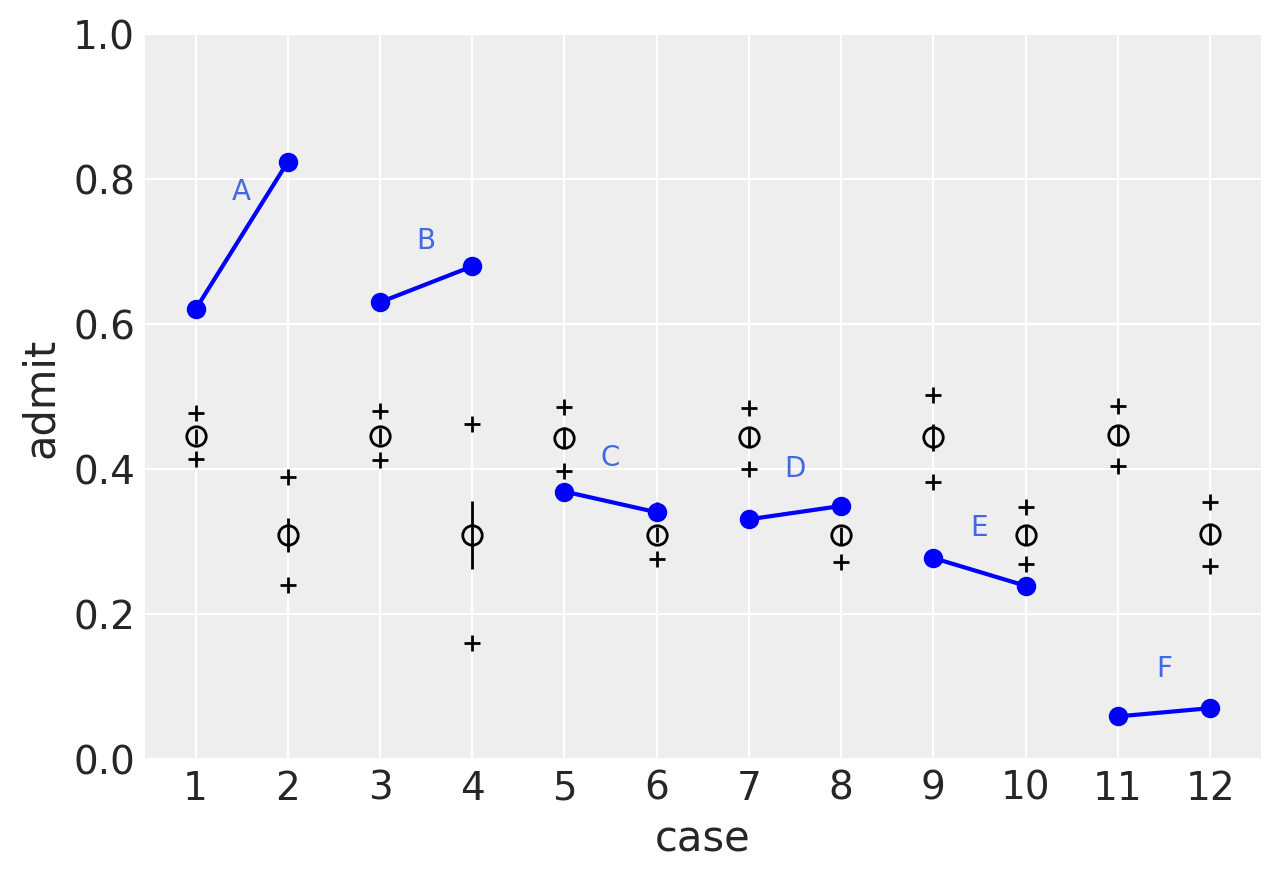

In [56]:
admit_rate = predictive_samples / N

plt.errorbar(range(1, 13), np.mean(admit_rate, 0), np.std(admit_rate, 0) / 2,
             fmt="o", c="k", mfc="none", ms=7, elinewidth=1)
plt.plot(range(1, 13), np.percentile(admit_rate, 5.5, 0), "k+")
plt.plot(range(1, 13), np.percentile(admit_rate, 94.5, 0), "k+")
# draw lines connecting points from same dept
for i in range(1, 7):
    x = 1 + 2 * (i - 1)
    y1 = d.admit.iloc[x - 1] / d.applications.iloc[x - 1]
    y2 = d.admit.iloc[x] / d.applications.iloc[x]
    plt.plot((x, x + 1), (y1, y2), "bo-")
    plt.annotate(d.dept.iloc[x], (x + 0.5, (y1 + y2) / 2 + 0.05),
                 ha="center", color="royalblue")
plt.gca().set(ylim=(0, 1), xticks=range(1, 13), ylabel="admit", xlabel="case");

What above plot shows is that only for departments C & E, there was a lower rate of admissions for females. Now this is not in sync with what we observed earlier where the model was telling that females should expect an overall 14% lower chance of admission. 

What is going on ?

Problem here is that male and females do not apply to same departments & departments also vary in their rate of admissions. Females do not apply to A & B that has higher rate of acceptance. Instead they applied to departments that have lower rate (10% of applicants) of acceptance.



## Code 11.32

Changing the question to be asked -

Instead of asking - 

*What are the average probabilities of admission for females and males across all departments?* 

we are now going to ask -

*What is the average difference in probability of admis- sion between females and males within departments?*

In [57]:
# construct 6 unique indexes such that there are 2 entries per index
dept_id = np.repeat(np.arange(6), 2)

def model_11_8(gid, dept_id, N):
    def _generator():      
      alpha = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1.5), sample_shape=2))
      delta = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1.5), sample_shape=6))
        
      p = tf.sigmoid(tf.squeeze(tf.gather(alpha, gid, axis=-1)) + tf.squeeze(tf.gather(delta, dept_id, axis=-1)))
        
      A = yield tfd.Independent(tfd.Binomial(total_count=N, probs=p), reinterpreted_batch_ndims=1)             
      
    return tfd.JointDistributionCoroutine(_generator, validate_args=True)    
    
jdc_11_8 = model_11_8(d.gid.values, dept_id, tf.cast(d.applications.values, dtype=tf.float32))

In [58]:
admit_values = tf.constant(d.admit.values, dtype=tf.float32)

init_state = [
  tf.zeros([NUMBER_OF_CHAINS, 2]),
  tf.zeros([NUMBER_OF_CHAINS, 6]),
]

bijectors = [
    tfb.Identity(),
    tfb.Identity()
]

trace_11_8 = sample_posterior(jdc_11_8, 
                                       observed_data=(admit_values,), 
                                       params=['alpha', 'delta'], 
                                       init_state=init_state,
                                       bijectors=bijectors,
                                       num_samples=2000)

az.summary(trace_11_8)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha[0],-0.584,0.443,-1.425,0.192,0.060,0.043,54.0,54.0,55.0,171.0,1.02
alpha[1],-0.486,0.445,-1.274,0.337,0.060,0.043,54.0,54.0,55.0,180.0,1.02
delta[0],1.165,0.446,0.353,1.979,0.060,0.043,55.0,55.0,55.0,172.0,1.02
delta[1],1.121,0.449,0.352,2.010,0.061,0.043,55.0,55.0,56.0,170.0,1.02
delta[2],-0.097,0.449,-0.884,0.774,0.061,0.043,55.0,55.0,55.0,160.0,1.02
delta[3],-0.127,0.448,-0.914,0.738,0.060,0.043,55.0,55.0,55.0,178.0,1.02
delta[4],-0.573,0.453,-1.372,0.303,0.061,0.043,55.0,55.0,56.0,194.0,1.02
delta[5],-2.127,0.462,-2.970,-1.277,0.060,0.043,59.0,59.0,60.0,198.0,1.02


## Code 11.33

Computing the contrast

In [59]:
posterior_11_8 = trace_11_8.posterior

In [60]:
diff_a = posterior_11_8["alpha"][:,:, 0] - posterior_11_8["alpha"][:,:, 1]
diff_p = tf.sigmoid(posterior_11_8["alpha"][:,:, 0].values) - tf.sigmoid(posterior_11_8["alpha"][:,:, 1].values)

posterior_11_8["diff_a"] = diff_a

coords = [posterior_11_8.coords['chain'], posterior_11_8.coords['draw']]
posterior_11_8["diff_p"] = xr.DataArray(diff_p, coords=coords,  dims=['chain', 'draw'])

az.summary(trace_11_8)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha[0],-0.584,0.443,-1.425,0.192,0.060,0.043,54.0,54.0,55.0,171.0,1.02
alpha[1],-0.486,0.445,-1.274,0.337,0.060,0.043,54.0,54.0,55.0,180.0,1.02
delta[0],1.165,0.446,0.353,1.979,0.060,0.043,55.0,55.0,55.0,172.0,1.02
delta[1],1.121,0.449,0.352,2.010,0.061,0.043,55.0,55.0,56.0,170.0,1.02
delta[2],-0.097,0.449,-0.884,0.774,0.061,0.043,55.0,55.0,55.0,160.0,1.02
delta[3],-0.127,0.448,-0.914,0.738,0.060,0.043,55.0,55.0,55.0,178.0,1.02
delta[4],-0.573,0.453,-1.372,0.303,0.061,0.043,55.0,55.0,56.0,194.0,1.02
delta[5],-2.127,0.462,-2.970,-1.277,0.060,0.043,59.0,59.0,60.0,198.0,1.02
diff_a,-0.098,0.081,-0.249,0.052,0.002,0.002,1170.0,1079.0,1170.0,1102.0,1.00
diff_p,-0.022,0.018,-0.055,0.013,0.001,0.000,1002.0,885.0,999.0,1068.0,1.01


## Code 11.34

In [61]:
pg = np.stack(list(map(
    lambda k: np.divide(d.applications[dept_id == k].values,
                        d.applications[dept_id == k].sum()), range(6))), axis=0).T
pg = pd.DataFrame(pg, index=["male", "female"], columns=d.dept.unique())
pg.round(2)

,A,B,C,D,E,F
male,0.88,0.96,0.35,0.53,0.33,0.52
female,0.12,0.04,0.65,0.47,0.67,0.48


Department A receives 88% of its applications from males. Department E receives 33% from males. 

## Code 11.35


Binomial is good when the count is known but quite often it is not the case.

When the count goes extremely high then mean and variance of Binomial starts to become same and this is known as Poisson Distribution


In [62]:
y = tfd.Binomial(1000, probs=1 / 1000).sample((int(1e5),))
tf.reduce_mean(y).numpy(), np.var(y)

(1.0008, 1.0020192)

Useful for binomial events for which the number of trials N is unknown or uncountably large.

## Code 11.36

Counts of unique tool types for 10 historical Oceanic societies

In [63]:
d = pd.read_csv(KLINE_DATASET_PATH, sep=";")
d

,culture,population,contact,total_tools,mean_TU
0,Malekula,1100,low,13,3.2
1,Tikopia,1500,low,22,4.7
2,Santa Cruz,3600,low,24,4.0
3,Yap,4791,high,43,5.0
4,Lau Fiji,7400,high,33,5.0
5,Trobriand,8000,high,19,4.0
6,Chuuk,9200,high,40,3.8
7,Manus,13000,low,28,6.6
8,Tonga,17500,high,55,5.4
9,Hawaii,275000,low,71,6.6


To remember - Number of rows in count based models is not same as the sample size

## Code 11.37

Here the outcome variable is **total tools**

We want to establish a relationship between **log population** and our outcome variable.

We also want to see the interaction between **contact** and **log population**

So first and foremost let's create a column for **log population**


In [64]:
d["P"] = d.population.pipe(np.log).pipe(lambda x: (x - x.mean()) / x.std())
d["cid"] = (d.contact == "high").astype(int)

## Code 11.38

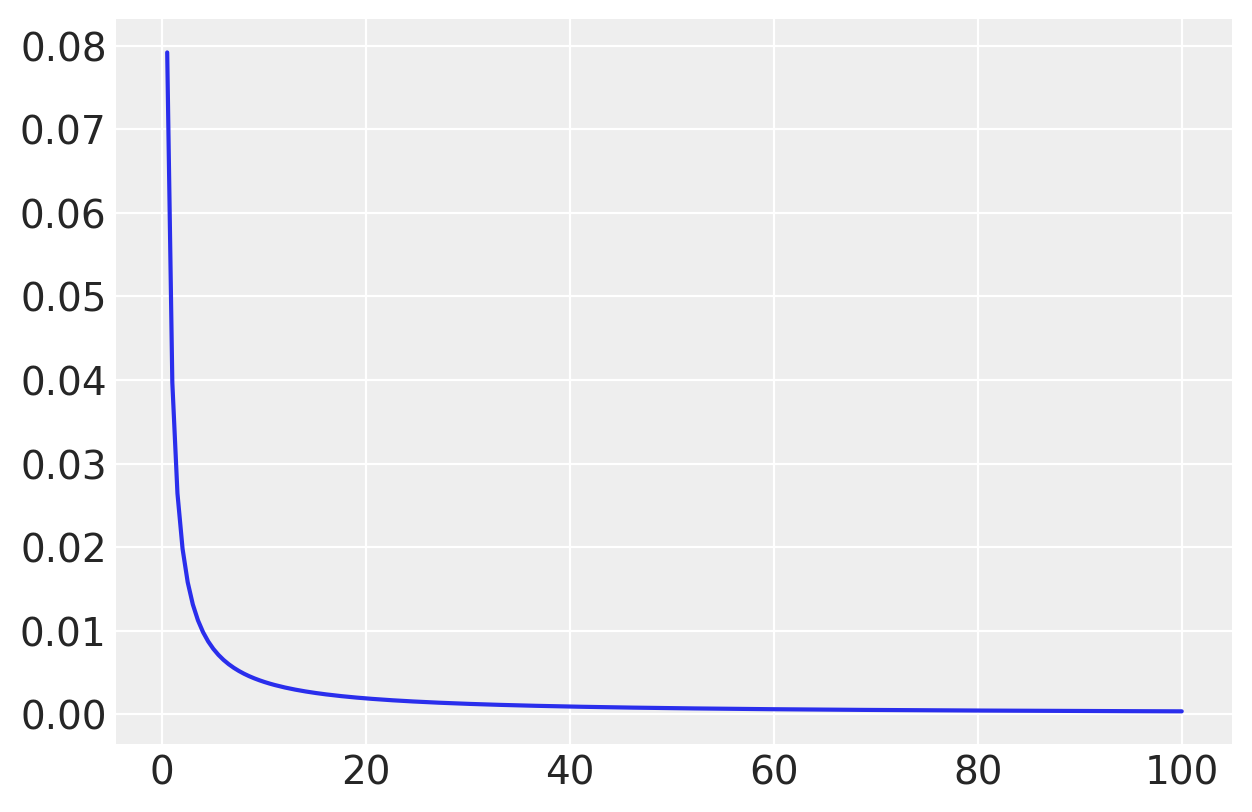

In [65]:
x = np.linspace(0, 100, 200)
plt.plot(x, tf.exp(tfd.LogNormal(loc=0., scale=10.).log_prob(x)));

## Code 11.39

In [66]:
a = tfd.Normal(loc=0., scale=10.).sample(int(1e4))
lambda_ = tf.exp(a)
tf.reduce_mean(lambda_)

<tf.Tensor: shape=(), dtype=float32, numpy=3324168400000.0>

## Code 11.40

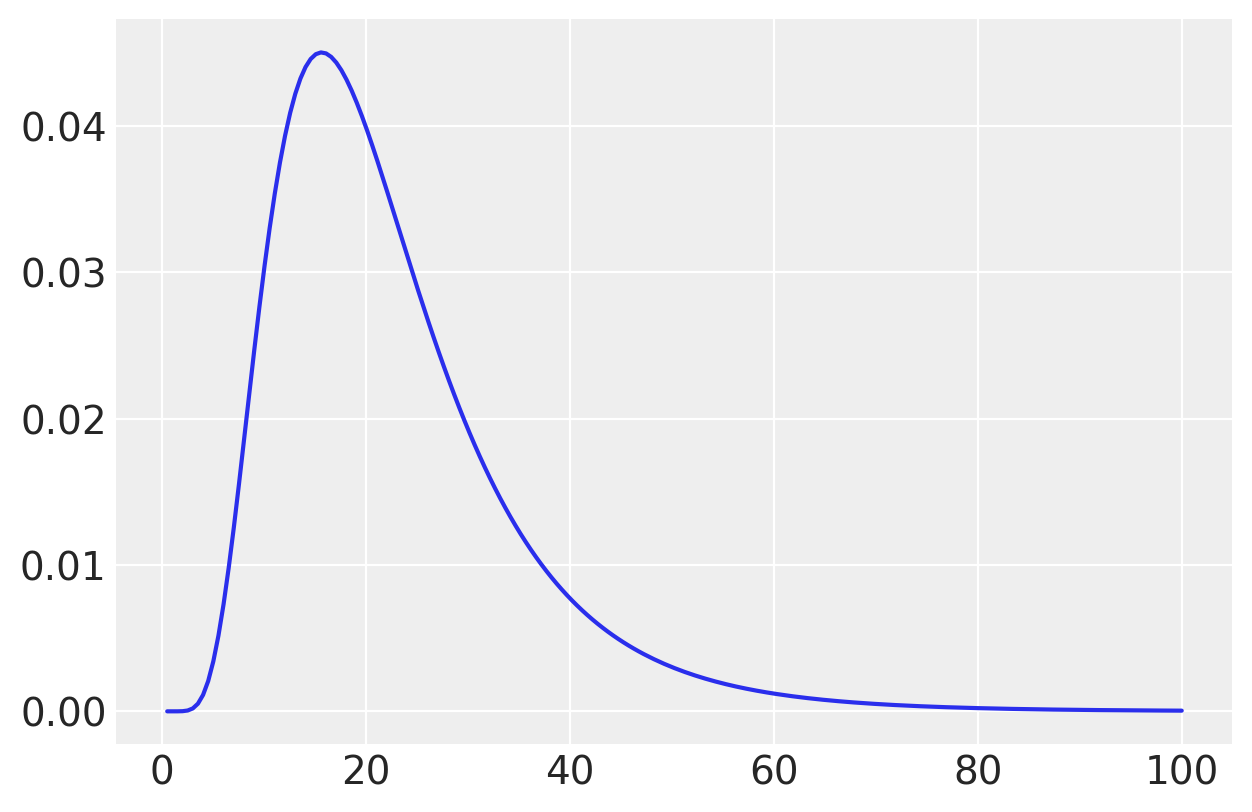

In [67]:
x = np.linspace(0, 100, 200)
plt.plot(x, tf.exp(tfd.LogNormal(loc=3., scale=0.5).log_prob(x)));


## Code 11.41

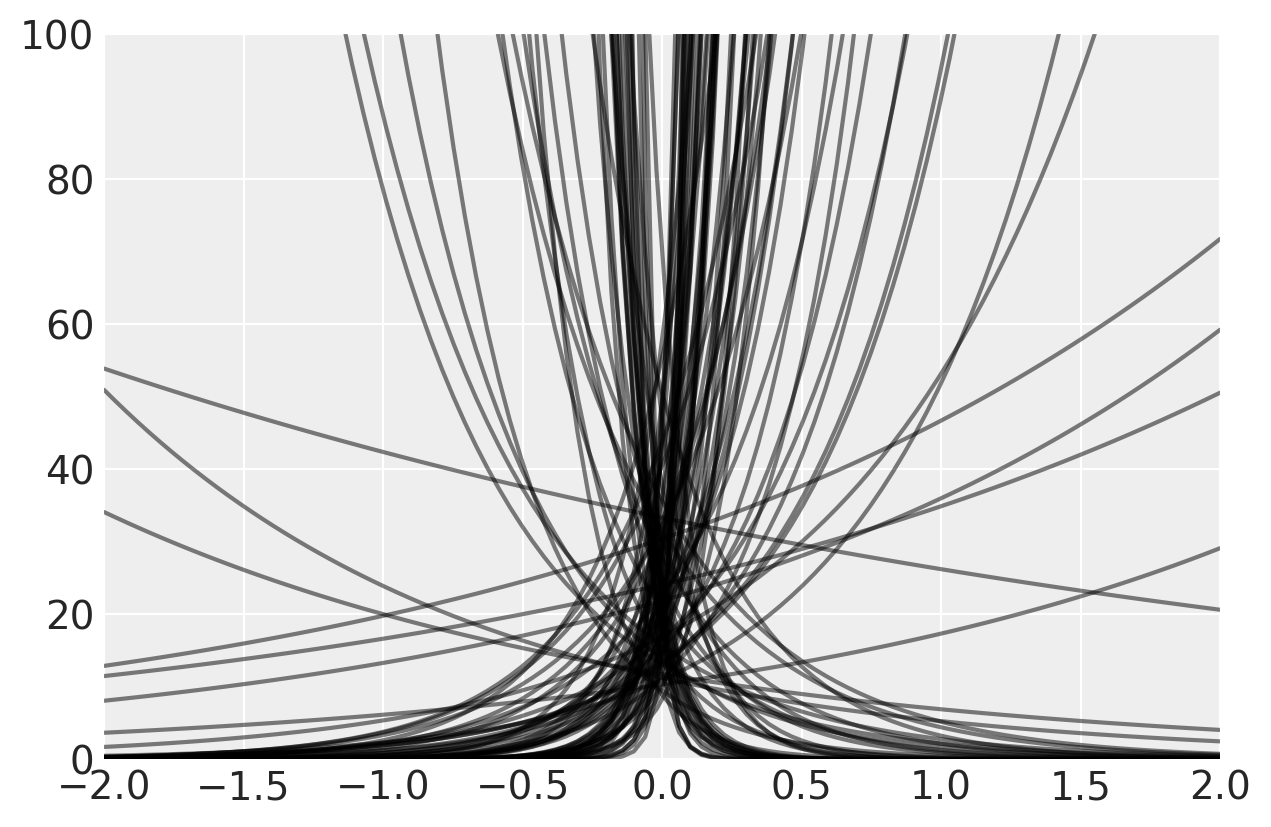

In [68]:
N = 100
a = tfd.Normal(loc=3., scale=0.5).sample(N)
b = tfd.Normal(loc=0., scale=10.).sample(N)
plt.subplot(xlim=(-2, 2), ylim=(0, 100))
x = np.linspace(-2, 2, 100)
for i in range(N):
    plt.plot(x, tf.exp(a[i] + b[i] * x), c="k", alpha=0.5)

## Code 11.42

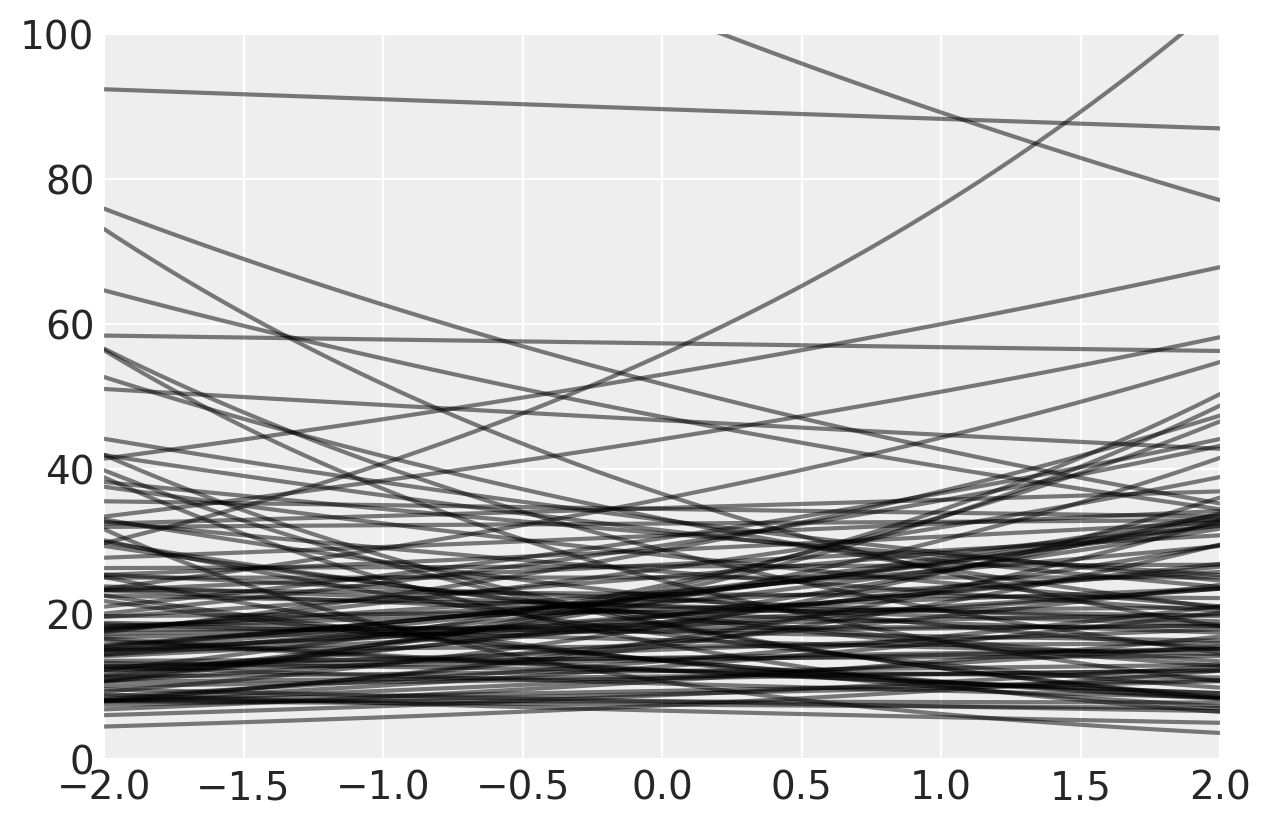

In [69]:
N = 100
a = tfd.Normal(loc=3., scale=0.5).sample(N).numpy()
b = tfd.Normal(loc=0., scale=0.2).sample(N).numpy()
plt.subplot(xlim=(-2, 2), ylim=(0, 100))
x = np.linspace(-2, 2, 100)
for i in range(N):
    plt.plot(x, tf.exp(a[i] + b[i] * x), c="k", alpha=0.5)

## Code 11.43

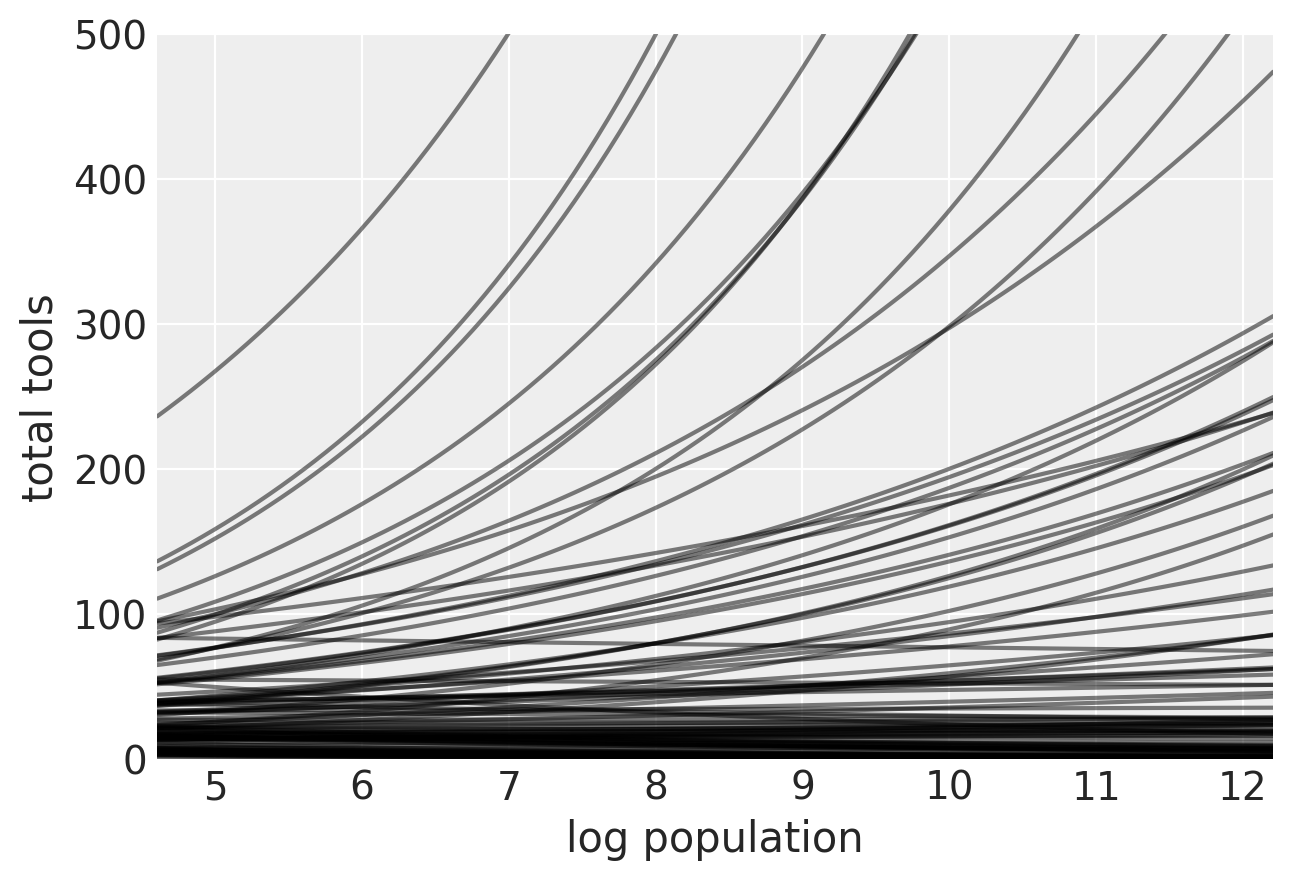

In [70]:
x_seq = np.linspace(np.log(100), np.log(200000), num=100)
lambda_ = np.array(list(map(lambda x: np.exp(a + b * x), x_seq)))

plt.subplot(xlim=(np.min(x_seq).item(), np.max(x_seq).item()), ylim=(0, 500),
            xlabel="log population", ylabel="total tools")

plt.plot(x_seq ,lambda_, c="k", alpha=0.5);

## Code 11.44

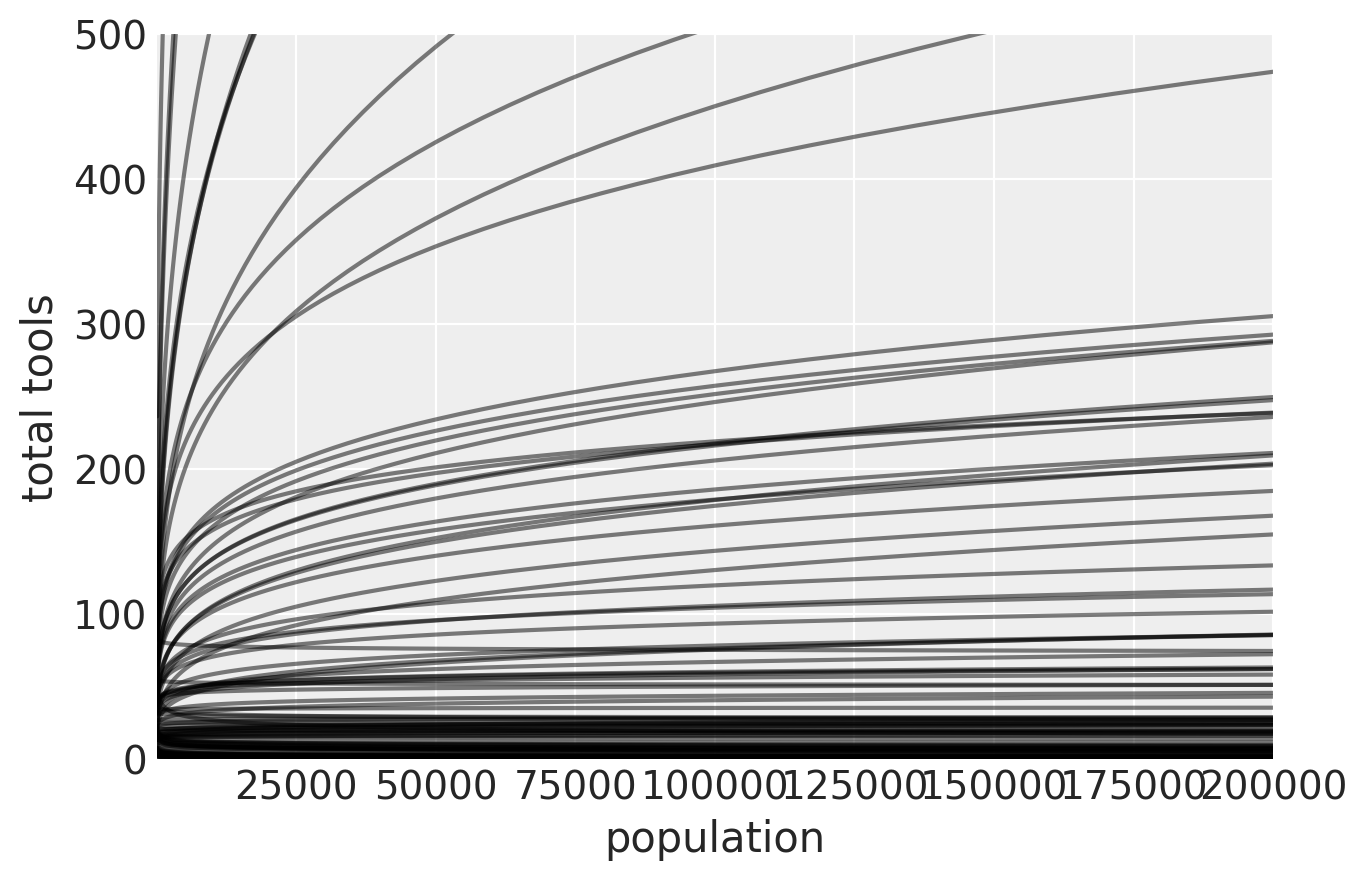

In [71]:
plt.subplot(xlim=(np.min(np.exp(x_seq)).item(), np.max(np.exp(x_seq)).item()),
            ylim=(0, 500), xlabel="population", ylabel="total tools")
plt.plot(np.exp(x_seq), lambda_, c="k", alpha=0.5);

## Code 11.45

In [72]:
dat = dict(T=d.total_tools.values, P=d.P.values, cid=d.cid.values)

In [73]:
d.total_tools.values

array([13, 22, 24, 43, 33, 19, 40, 28, 55, 71])

In [74]:
# intercept only
def model_11_9():
    def _generator():      
      alpha = yield Root(tfd.Sample(tfd.Normal(loc=3., scale=0.5), sample_shape=1))
      lambda_ = tf.exp(alpha[...,tf.newaxis])
        
      T = yield tfd.Independent(tfd.Poisson(rate=lambda_), reinterpreted_batch_ndims=1)             
      
    return tfd.JointDistributionCoroutine(_generator, validate_args=True)    
    
jdc_11_9 = model_11_9()

init_state = [
   3. * tf.zeros([NUMBER_OF_CHAINS])
]

bijectors = [
    tfb.Identity()
]

trace_11_9 = sample_posterior(jdc_11_9, 
                                   observed_data=(dat["T"],), 
                                   init_state=init_state,
                                   bijectors=bijectors,
                                   params=['alpha'])

In [75]:
# interaction model
def model_11_10(cid, P):
    def _generator():      
      alpha = yield Root(tfd.Sample(tfd.Normal(loc=3., scale=0.5), sample_shape=2))
      beta = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.2), sample_shape=2))
        
      lambda_ = tf.exp(
                  tf.squeeze(tf.gather(alpha, cid, axis=-1)) + \
                  tf.squeeze(tf.gather(beta, cid, axis=-1)) * P
              )
                
        
      T = yield tfd.Independent(tfd.Poisson(rate=lambda_), reinterpreted_batch_ndims=1)             
      
    return tfd.JointDistributionCoroutine(_generator, validate_args=True)    
    
jdc_11_10 = model_11_10(dat["cid"], dat["P"])

init_state = [
    tf.zeros([NUMBER_OF_CHAINS, 2]),
    tf.zeros([NUMBER_OF_CHAINS, 2])
]

bijectors = [
    tfb.Identity(),
    tfb.Identity()
]

trace_11_10 = sample_posterior(jdc_11_10, 
                                observed_data=(dat["T"],),
                                init_state=init_state,
                                bijectors=bijectors,
                                params=['alpha', 'beta'])

## Code 11.46  

In [76]:
# We need to compute the log likelihood for model_11_9
# and then store it in the trace_11_9
#
# Reason to store it as it is expected by az.compare

def compute_and_store_log_likelihood_for_model_11_9():

    def log_like_11_9(a):
        return tfd.Poisson(rate=tf.exp(a)).log_prob(dat["T"])

    log_likelihood_11_9 = []

    for i in range(NUMBER_OF_CHAINS):
        alpha = trace_11_9.posterior["alpha"].values[i]
        log_likelihood = np.array(list(map(log_like_11_9, alpha)))
        log_likelihood_11_9.append(log_likelihood)

    log_likelihood_11_9 = np.array(log_likelihood_11_9)

    # we need to insert this in the sampler_stats
    sample_stats_11_9 = trace_11_9.sample_stats

    coords = [sample_stats_11_9.coords['chain'], sample_stats_11_9.coords['draw'], np.arange(10)]

    sample_stats_11_9["log_likelihood"] = xr.DataArray(
        log_likelihood_11_9, 
        coords=coords,  
        dims=['chain', 'draw', 'log_likelihood_dim_0'])
    
compute_and_store_log_likelihood_for_model_11_9()

In [77]:
# We need to compute the log likelihood for model_11_10
# and then store it in the trace_11_10
#
# Reason to store it as it is expected by az.compare

def compute_and_store_log_likelihood_for_model_11_10():

    def log_like_11_10(params):
        a = params[0]
        b = params[1]       

        lambda_ = tf.exp(
                      tf.squeeze(tf.gather(a, dat["cid"], axis=-1)) + \
                      tf.squeeze(tf.gather(b, dat["cid"], axis=-1)) * dat["P"]
                  )    

        return tfd.Poisson(rate=lambda_).log_prob(dat["T"])


    log_likelihood_11_10 = []

    for i in range(NUMBER_OF_CHAINS):
        alpha = trace_11_10.posterior["alpha"].values[i]
        beta = trace_11_10.posterior["beta"].values[i]
        log_likelihood = np.array(list(map(log_like_11_10, zip(alpha, beta))))
        log_likelihood_11_10.append(log_likelihood)

    log_likelihood_11_10 = np.array(log_likelihood_11_10)

    # we need to insert this in the sampler_stats
    sample_stats_11_10 = trace_11_10.sample_stats

    coords = [sample_stats_11_10.coords['chain'], sample_stats_11_10.coords['draw'], np.arange(10)]

    sample_stats_11_10["log_likelihood"] = xr.DataArray(
        log_likelihood_11_10, 
        coords=coords,  
        dims=['chain', 'draw', 'log_likelihood_dim_0'])

compute_and_store_log_likelihood_for_model_11_10()

In [78]:
az.compare({"m11.9": trace_11_9,
            "m11.10": trace_11_10}, ic="loo")

/Users/ksachdeva/Desktop/Dev/myoss/rethinking-tensorflow-probability/env/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/Users/ksachdeva/Desktop/Dev/myoss/rethinking-tensorflow-probability/env/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more 

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m11.10,0,84.4808,6.57228,0,0.996469,30.8367,0,True,deviance
m11.9,1,141.292,8.14739,56.8115,0.0035313,12.0027,31.6435,True,deviance


## Code 11.47

/Users/ksachdeva/Desktop/Dev/myoss/rethinking-tensorflow-probability/env/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


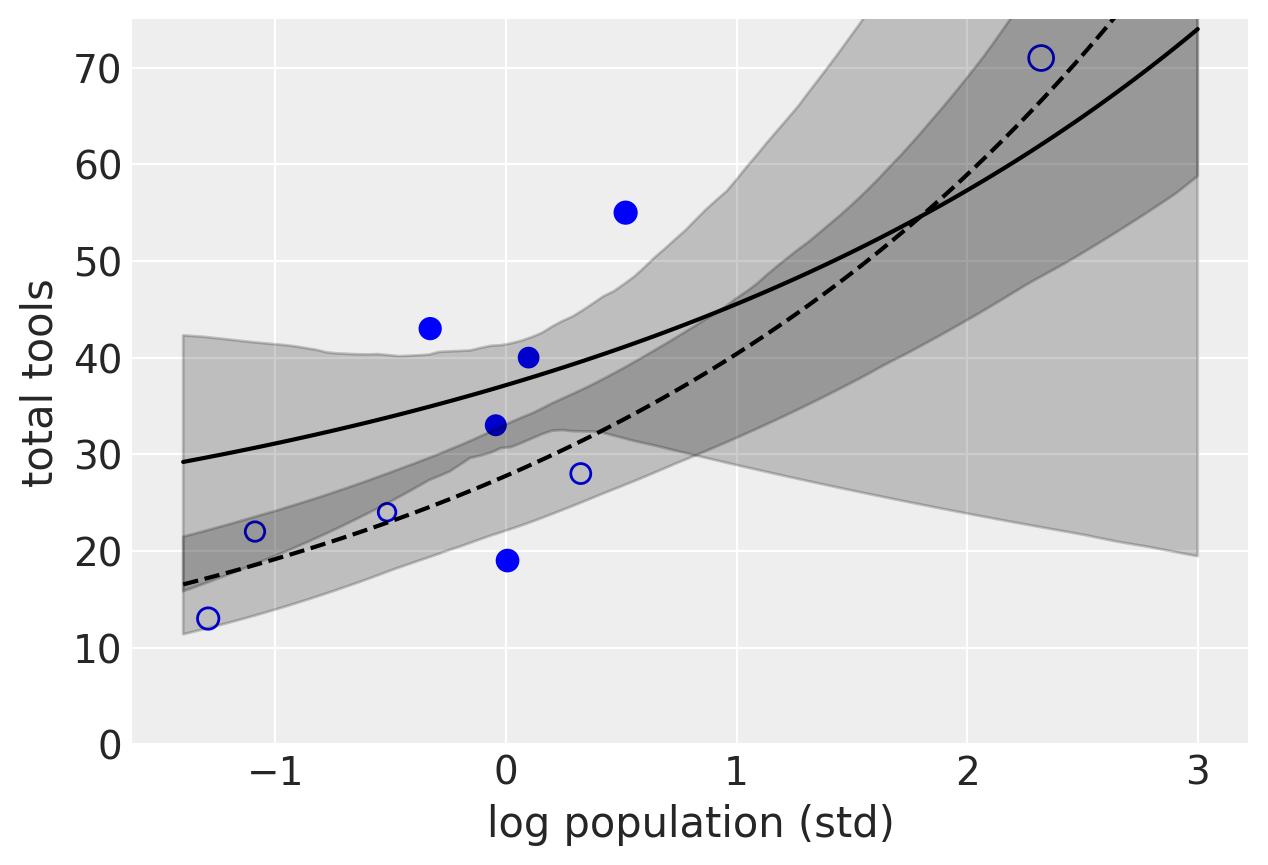

In [79]:
k = az.loo(trace_11_10, pointwise=True).pareto_k.values

cex = 1 + (k - np.min(k)) / (np.max(k) - np.min(k))
plt.scatter(dat["P"], dat["T"], s=40 * cex,
            edgecolors=["none" if i == 1 else "b" for i in dat["cid"]],
            facecolors=["none" if i == 0 else "b" for i in dat["cid"]])
plt.gca().set(xlabel="log population (std)", ylabel="total tools",
              ylim=(0, 75))

# set up the horizontal axis values to compute predictions at
ns = 100
P_seq = np.linspace(-1.4, 3, num=ns)


# only using chain 0
sample_alpha = trace_11_10.posterior["alpha"].values[0]
sample_beta = trace_11_10.posterior["beta"].values[0]


def predict_and_plot(cid):
    term1 = tf.gather(sample_alpha, [cid], axis=-1)
    term2 = tf.gather(sample_beta, [cid], axis=-1) * P_seq
    lambda_ = tf.exp(term1 + term2).numpy()
    lmu = np.mean(lambda_, 0)
    lci = np.percentile(lambda_, (0.55, 94.5), 0)
    if cid == 0:
        plt.plot(P_seq, lmu, "k--", lw=1.5)
    else:
        plt.plot(P_seq, lmu, "k", lw=1.5)
    plt.fill_between(P_seq, lci[0], lci[1], color="k", alpha=0.2)


# make predictions when cid = 1 i.e. have low contact
predict_and_plot(0)
predict_and_plot(1)

Open points are low contact societies and closed points are the high contact ones. Dashed curve is the posterior mean for low contact societies.

## Code 11.48

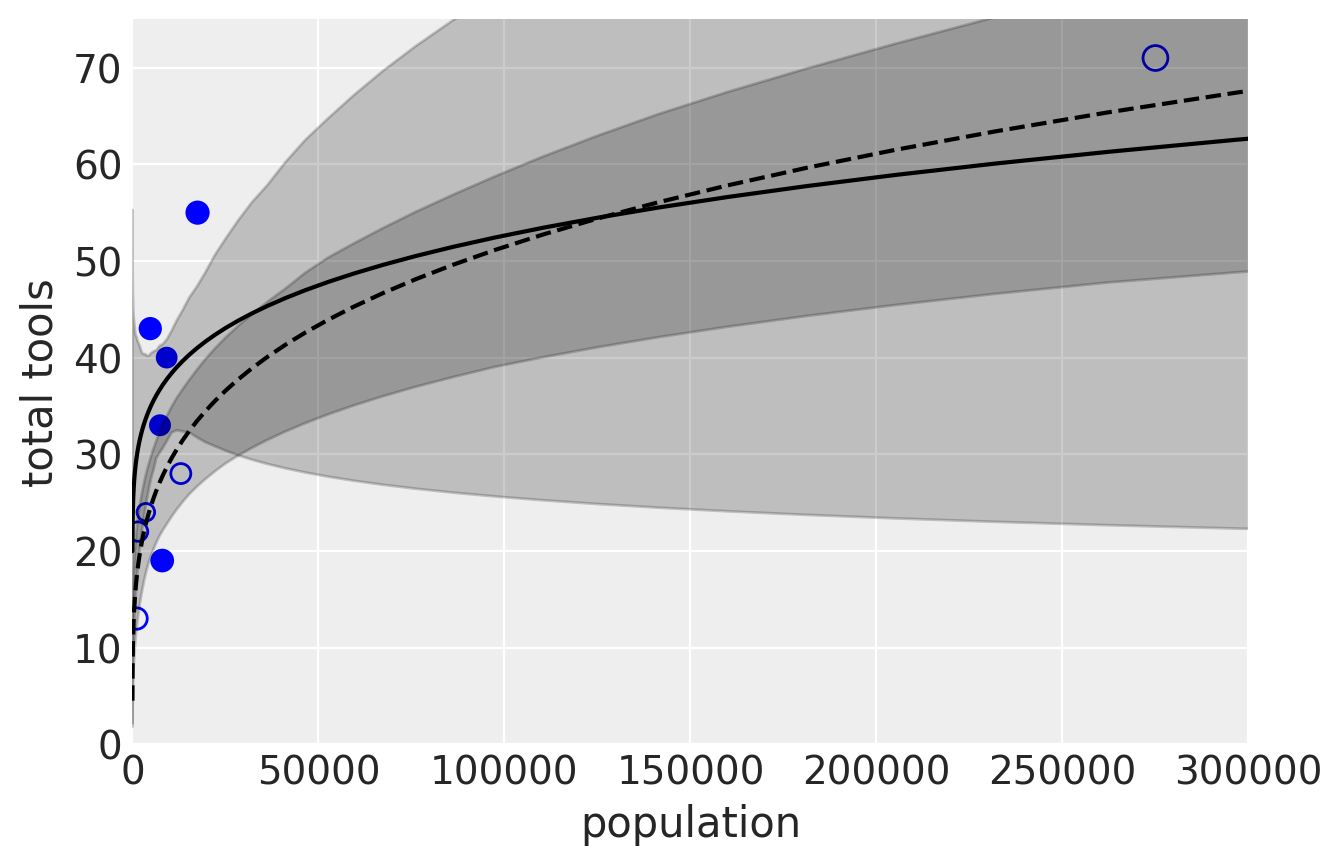

In [80]:
cex = 1 + (k - np.min(k)) / (np.max(k) - np.min(k))

plt.scatter(d.population, d.total_tools, s=40 * cex,
            edgecolors=["none" if i == 1 else "b" for i in dat["cid"]],
            facecolors=["none" if i == 0 else "b" for i in dat["cid"]])
plt.gca().set(xlabel="population", ylabel="total tools",
              xlim=(0, 300000), ylim=(0, 75))

ns = 100
P_seq = np.linspace(-5, 3, num=ns)
# 1.53 is sd of log(population)
# 9 is mean of log(population)
pop_seq = np.exp(P_seq * 1.53 + 9)


def predict_and_plot(cid):
    term1 = tf.gather(sample_alpha, [cid], axis=-1)
    term2 = tf.gather(sample_beta, [cid], axis=-1) * P_seq
    lambda_ = tf.exp(term1 + term2).numpy()
    lmu = np.mean(lambda_, 0)
    lci = np.percentile(lambda_, (0.55, 94.5), 0)
    if cid == 0:
        plt.plot(pop_seq, lmu, "k--", lw=1.5)
    else:
        plt.plot(pop_seq, lmu, "k", lw=1.5)
    plt.fill_between(pop_seq, lci[0], lci[1], color="k", alpha=0.2)


# make predictions when cid = 1 i.e. have low contact
predict_and_plot(0)
predict_and_plot(1)

## Code 11.49

In [81]:
dat2 = dict(T=d.total_tools.values, P=d.population.values,
            cid=d.cid.values)

def model_11_11(cid, P):
    def _generator():
        g = yield Root(tfd.Sample(tfd.Exponential(1.0), sample_shape=1))
        beta = yield Root(tfd.Sample(tfd.Exponential(1.0), sample_shape=2))
        alpha = yield Root(tfd.Sample(tfd.Normal(loc=1.0, scale=1.0), sample_shape=2))
        
        term1 = tf.exp(tf.squeeze(tf.gather(alpha, cid, axis=-1)))
        term2 = tf.pow(P, tf.squeeze(tf.gather(beta, cid, axis=-1))) / g
        
        lambda_ = term1 + term2
        
        T = yield tfd.Independent(tfd.Poisson(rate=lambda_), reinterpreted_batch_ndims=1)             
      
    return tfd.JointDistributionCoroutine(_generator, validate_args=True)    
        
        
jdc_11_11 = model_11_11(dat2["cid"], dat2["P"])


## Code 11.50

In [82]:
num_days = 30
y = tfd.Poisson(rate=1.5).sample((num_days,))

## Code 11.51

In [83]:
num_weeks = 4
y_new = tfd.Poisson(rate=0.5 * 7).sample((num_weeks,))

## Code 11.52

In [84]:
y_all = np.concatenate([y, y_new])
exposure = np.concatenate([np.repeat(1, 30), np.repeat(7, 4)])
monastery = np.concatenate([np.repeat(0, 30), np.repeat(1, 4)])
d = pd.DataFrame.from_dict(dict(y=y_all, days=exposure, monastery=monastery))

d

,y,days,monastery
0,1.0,1,0
1,4.0,1,0
2,1.0,1,0
3,0.0,1,0
4,1.0,1,0
5,2.0,1,0
6,3.0,1,0
7,0.0,1,0
8,5.0,1,0
9,0.0,1,0


## Code 11.53

In [85]:
# compute the offset
d["log_days"] = d.days.pipe(np.log)

def model_11_12(log_days, monastery):
    def _generator():
        a = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1.), sample_shape=1))
        b = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1.), sample_shape=1))
        
        lambda_ = tf.exp(log_days + a[...,tf.newaxis] + b[...,tf.newaxis] * monastery)
        
        T = yield tfd.Independent(tfd.Poisson(rate=lambda_), reinterpreted_batch_ndims=1)
        
    return tfd.JointDistributionCoroutine(_generator, validate_args=True)  
    
jdc_11_12 = model_11_12(d.log_days.values, d.monastery.values)

init_state = [
    tf.zeros([NUMBER_OF_CHAINS]),
    tf.zeros([NUMBER_OF_CHAINS])
]

bijectors = [
    tfb.Identity(),
    tfb.Identity()
]


trace_11_12 = sample_posterior(
    jdc_11_12, 
    observed_data=(d.y.values,), 
    init_state=init_state,
    bijectors=bijectors,
    params=["alpha", "beta"])

## Code 11.54

In [86]:
posterior_11_12 = trace_11_12.posterior

# using only the first chain
sample_alpha = posterior_11_12["alpha"][0:,].values
sample_beta = posterior_11_12["beta"][0:,].values

lambda_old = np.exp(sample_alpha)
lambda_new = np.exp(sample_alpha + sample_beta)


In [87]:
az.summary(az.from_dict({
    'lambda_old' : lambda_old,
    'lambda_new' : lambda_new
}))

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
lambda_old,1.319,0.219,0.942,1.693,0.013,0.010,282.0,262.0,298.0,318.0,1.02
lambda_new,0.483,0.134,0.248,0.724,0.008,0.005,318.0,318.0,243.0,114.0,1.01


## Code 11.55

Here we simulate career choice from three different careers, each with its own income trait. These traits are used to assign a score to each type of event. Then when the model is fit to the data, one of these scores is held constant, and the other two scores are estimated, using the known income traits

In [88]:
# simulate career choices among 500 individuals
N = 500  # number of individuals
income = np.array([1, 2, 5])  # expected income of each career
score = 0.5 * income  # scores for each career, based on income

# next line converts scores to probabilities
p = tf.nn.softmax(score)

# now simulate choice
# outcome career holds event type values, not counts
career = np.repeat(np.nan, N)  # empty vector of choices for each individual

# sample chosen career for each individual
for i in range(N):
    career[i] = tfd.Categorical(probs=p).sample()
    
career = career.astype(int)


## Code 11.56


Categorical likelihood is a multinomial logistic regression distribution.

Each possible career will gets its own linear model with its own features. 

In [89]:
def model_11_13(N, K, career_income):
    def _generator():
        print("==== start")
        # intercepts
        alpha = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1.), sample_shape=(K-1)))
        # association of income with choice
        beta = yield Root(tfd.Sample(tfd.HalfNormal(scale=0.5), sample_shape=1))
        
        print("alpja", alpha.shape)
        print("beta", beta.shape)
        
        s_1 = tf.gather(alpha, [0], axis=-1) + beta * career_income[0]
        s_2 = tf.gather(alpha, [1], axis=-1) + beta * career_income[1]
        s_3 = tf.zeros_like(s_1)  # pivot
        
        print("s1",s_1.shape)
        print("s2", s_2.shape)
        
        ts = tf.stack([s_1, s_2, s_3], axis=1)
        
        p = tf.nn.softmax(ts)
        
        print("p",p.shape)
        
        p_p = p
        print("==== end")
        
        career = yield tfd.Independent(tfd.Categorical(probs=p_p), reinterpreted_batch_ndims=1)
        
    return tfd.JointDistributionCoroutine(_generator, validate_args=True)

## Code 11.57 (TODO - not able to make it work with 2 chains)

In [90]:
jdc_11_13 = model_11_13(N,3,income)

jdc_11_13.sample(2)

==== start
alpja (2, 2)
beta (2, 1)
s1 (2, 1)
s2 (2, 1)
p (2, 3, 1)
==== end


(<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[-0.57857466, -0.18503314],
        [ 1.7390041 , -1.5211076 ]], dtype=float32)>,
 <tf.Tensor: shape=(2, 1), dtype=float32, numpy=
 array([[0.12891531],
        [0.540106  ]], dtype=float32)>,
 <tf.Tensor: shape=(2, 3), dtype=int32, numpy=
 array([[0, 0, 0],
        [0, 0, 0]], dtype=int32)>)

In [91]:
NUMBER_OF_CHAINS_11_13 = 2

init_state = [
    tf.zeros([NUMBER_OF_CHAINS_11_13, 2]),
    tf.zeros([NUMBER_OF_CHAINS_11_13])
]

bijectors = [
    tfb.Identity(),
    tfb.Identity()
]

trace_11_13 = sample_posterior(jdc_11_13, 
                                    observed_data=(career,), 
                                    init_state=init_state,
                                    bijectors=bijectors,
                                    params=["alpha", "beta"])

==== start
alpja (2,)
beta (1,)
s1 (1,)
s2 (1,)
p (1, 3)
==== end
==== start
alpja (2, 2)
beta (2,)
s1 (2, 2)
s2 (2, 2)
p (2, 3, 2)
==== end


ValueError: Dimensions must be equal, but are 3 and 500 for 'mcmc_sample_chain/simple_step_size_adaptation___init__/_bootstrap_results/transformed_kernel_bootstrap_results/mh_bootstrap_results/hmc_kernel_bootstrap_results/maybe_call_fn_and_grads/value_and_gradients/JointDistributionCoroutine/log_prob/mcmc_sample_chain_simple_step_size_adaptation___init____bootstrap_results_transformed_kernel_bootstrap_results_mh_bootstrap_results_hmc_kernel_bootstrap_results_maybe_call_fn_and_grads_value_and_gradients_JointDistributionCoroutine_log_prob_Independentmcmc_sample_chain_simple_step_size_adaptation___init____bootstrap_results_transformed_kernel_bootstrap_results_mh_bootstrap_results_hmc_kernel_bootstrap_results_maybe_call_fn_and_grads_value_and_gradients_JointDistributionCoroutine_log_prob_Categorical/log_prob/mcmc_sample_chain_simple_step_size_adaptation___init____bootstrap_results_transformed_kernel_bootstrap_results_mh_bootstrap_results_hmc_kernel_bootstrap_results_maybe_call_fn_and_grads_value_and_gradients_JointDistributionCoroutine_log_prob_Categorical/log_prob/mul' (op: 'Mul') with input shapes: [2,3,2], [500,1].

In [ ]:
az.summary(trace_11_13)